In [1]:
## Making a viz for Paul's nature paper

In [21]:
#1.Imports
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import glob
import rasterio
from rasterio.mask import mask
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.gridspec import GridSpec
from shapely.ops import transform
import pyproj

In [24]:
# 2. Make spatial overlap gdf

#Load chip GeoDataFrames
gdf_chips_ifsar = gpd.read_file('/explore/nobackup/people/mmacande/srlite/chm_model/20231014_chm/chips_df_ifsar_chm_nodtm_v20231014.gpkg')
gdf_chips_ifsar['source'] = 'IFSAR'
gdf_chips_lidar = gpd.read_file('/explore/nobackup/people/mmacande/srlite/chm_model/20231014_chm/chips_df_lidar_nodtm_v20231014.gpkg')
gdf_chips_lidar['source'] = 'LIDAR'

# Spatial join to get overlapping rows
gdf_overlap = gpd.sjoin(gdf_chips_ifsar, gdf_chips_lidar, how='inner', predicate='intersects')

# Find SRLite files
search_dir = "/explore/nobackup/projects/above/misc/ABoVE_Shrubs/srlite/002m_2023"

def find_matching_file(basename, search_dir):
    pattern = os.path.join(search_dir, f"*{basename}*")
    matches = glob.glob(pattern)
    if len(matches) == 1:
        return matches[0]
    elif len(matches) > 1:
        return matches
    else:
        return None

gdf_overlap['srlite_real_path'] = gdf_overlap['baseName_left'].apply(
    lambda x: find_matching_file(x, search_dir)
)

print(f"Files found: {gdf_overlap['srlite_real_path'].notna().sum()}")
print(f"Files not found: {gdf_overlap['srlite_real_path'].isna().sum()}")

Files found: 4691
Files not found: 0


In [25]:
## 3. Create subset of 4 types
# Reset index and add row number
gdf_overlap = gdf_overlap.reset_index(drop=True)
gdf_overlap['row_number'] = gdf_overlap.index

# Define vegetation type assignments
vegetation_types = {
    'Tundra': [66],
    'Woody (sparse)': [319],
    'Woody (dense)': [458],
    'Mixed': [204]  
}

# Other examples if want to use instead
# vegetation_types = {
#     'Tundra': [66, 108, 118, 123],
#     'Woody (sparse)': [183, 186, 213, 319, 418, 489, 540],
#     'Woody (dense)': [122, 146, 235, 270, 287, 413, 458],
#     'Mixed': [97, 144, 204, 356, 476, 578, 579]  
# }

# Assign vegetation types
gdf_overlap['vegetation_type'] = None
for veg_type, rows in vegetation_types.items():
    for row in rows:
        gdf_overlap.loc[row, 'vegetation_type'] = veg_type

# Extract selected rows
all_rows = [row for rows in vegetation_types.values() for row in rows]
gdf_for_viz = gdf_overlap.loc[all_rows].copy()

print(f"Total rows in gdf_for_viz: {len(gdf_for_viz)}")
print(gdf_for_viz['vegetation_type'].value_counts())

Total rows in gdf_for_viz: 4
vegetation_type
Tundra            1
Woody (sparse)    1
Woody (dense)     1
Mixed             1
Name: count, dtype: int64


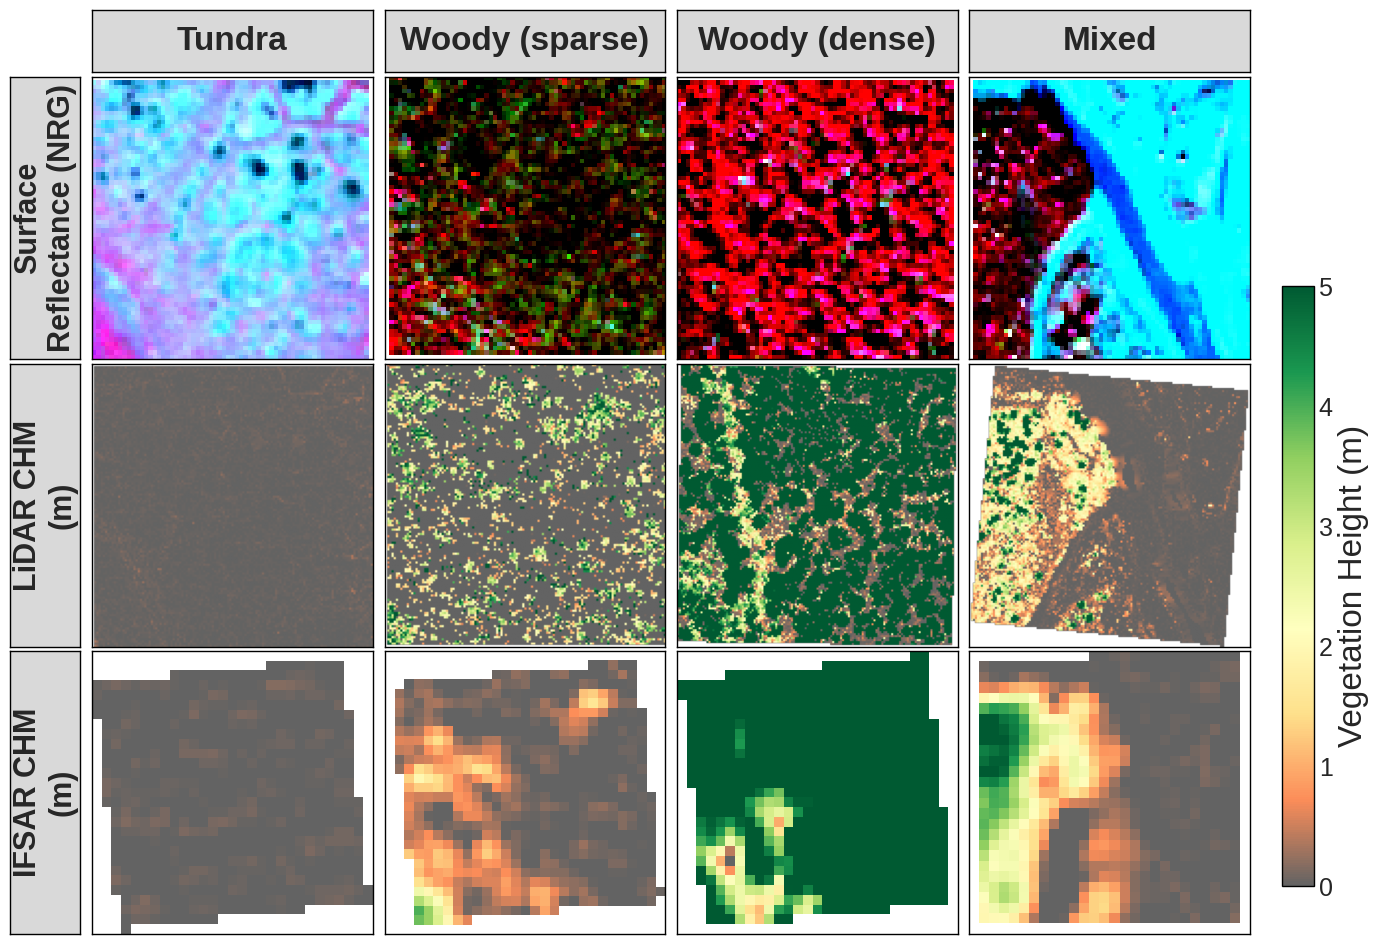

Saved to: /explore/nobackup/projects/above/misc/ABoVE_Shrubs/vegetation_comparison.png


<Figure size 640x480 with 0 Axes>

In [30]:
# 4. Make the Visualization
import rasterio
from rasterio.mask import mask
import matplotlib.pyplot as plt
import numpy as np
from shapely.ops import transform
import pyproj
from matplotlib.colors import LinearSegmentedColormap, Normalize
import pandas as pd
from matplotlib.gridspec import GridSpec

# Set ggplot theme_bw style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['figure.facecolor'] = 'white'

# Stretch values
stretch_params = {
    'nir_min': 1549,
    'nir_max': 3020,
    'red_min': 550,
    'red_max': 805,
    'green_min': 579,
    'green_max': 706,
    'blue_min': 430,
    'blue_max': 472,
}

# Colormap setup
forest_ht_colors = ['#636363', '#fc8d59', '#fee08b', '#ffffbf',
                    '#d9ef8b', '#91cf60', '#1a9850', '#005a32']
forest_ht_cmap = LinearSegmentedColormap.from_list('forest_ht', forest_ht_colors)
forest_ht_cmap.set_bad(alpha=0)

chm_max_value = 5
norm = Normalize(vmin=0, vmax=chm_max_value, clip=True)

# Functions
def clip_raster_with_geom(filepath, geometry, gdf_crs):
    with rasterio.open(filepath) as src:
        project = pyproj.Transformer.from_crs(
            gdf_crs, src.crs, always_xy=True
        ).transform
        reprojected_geom = transform(project, geometry)
        geom = [reprojected_geom.__geo_interface__]
        out_image, out_transform = mask(src, geom, crop=True)
        return out_image

def stretch_band_fixed(band, vmin, vmax, nodata=-9999):
    band = band.astype(float)
    band[band == nodata] = np.nan
    stretched = (band - vmin) / (vmax - vmin)
    return np.clip(stretched, 0, 1)

# Define vegetation type order
veg_order = ['Tundra', 'Woody (sparse)', 'Woody (dense)', 'Mixed']

# Sort gdf by custom order
gdf_for_viz['vegetation_type'] = pd.Categorical(
    gdf_for_viz['vegetation_type'], 
    categories=veg_order, 
    ordered=True
)
gdf_sorted = gdf_for_viz.sort_values('vegetation_type')

# Get GDF CRS
gdf_crs = gdf_for_viz.crs

# Collect all data first
all_data = {}

for idx, row in gdf_sorted.iterrows():
    veg_type = row['vegetation_type']
    
    files = {
        'SRLite': row['srlite_real_path'],
        'LiDAR CHM': row['chmPath_right'],
        'IFSAR CHM': row['chmPath_left'],
    }
    
    all_data[veg_type] = {}
    
    for name, filepath in files.items():
        try:
            arr = clip_raster_with_geom(filepath, row.geometry, gdf_crs)
            
            if 'CHM' in name:
                arr = arr.astype(float)
                arr[(arr > 40) | (arr < -5)] = np.nan
            
            all_data[veg_type][name] = arr
        except Exception as e:
            print(f"Error loading {name} for {veg_type}: {e}")
            all_data[veg_type][name] = None

# Create figure
fig = plt.figure(figsize=(16, 12), facecolor='white')

gs = GridSpec(4, 5, figure=fig, 
              height_ratios=[0.22, 1, 1, 1],
              width_ratios=[0.25, 1, 1, 1, 1],
              hspace=0.02, wspace=0.05)

row_labels = ['Surface\nReflectance (NRG)', 'LiDAR CHM\n(m)', 'IFSAR CHM\n(m)']
gray_color = '#d9d9d9'

# Add column label boxes
for col_idx, veg_type in enumerate(veg_order):
    ax_label = fig.add_subplot(gs[0, col_idx + 1])
    ax_label.set_facecolor(gray_color)
    ax_label.text(0.5, 0.5, veg_type, fontsize=24, fontweight='bold',
                  ha='center', va='center', transform=ax_label.transAxes)
    ax_label.set_xticks([])
    ax_label.set_yticks([])
    for spine in ax_label.spines.values():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1.0)

# Add row label boxes
for row_idx, label in enumerate(row_labels):
    ax_label = fig.add_subplot(gs[row_idx + 1, 0])
    ax_label.set_facecolor(gray_color)
    ax_label.text(0.5, 0.5, label, fontsize=22, fontweight='bold',
                  ha='center', va='center', rotation=90, transform=ax_label.transAxes,
                  linespacing=1.2)
    ax_label.set_xticks([])
    ax_label.set_yticks([])
    for spine in ax_label.spines.values():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1.0)

# Add image panels
for col_idx, veg_type in enumerate(veg_order):
    data = all_data[veg_type]
    
    # Row 0: SRLite
    ax = fig.add_subplot(gs[1, col_idx + 1])
    srlite_arr = data['SRLite']
    if srlite_arr is not None:
        nir = srlite_arr[3]
        red = srlite_arr[2]
        green = srlite_arr[1]
        
        nir_stretched = stretch_band_fixed(nir, stretch_params['nir_min'], stretch_params['nir_max'])
        red_stretched = stretch_band_fixed(red, stretch_params['red_min'], stretch_params['red_max'])
        green_stretched = stretch_band_fixed(green, stretch_params['green_min'], stretch_params['green_max'])
        
        rgb = np.dstack([nir_stretched, red_stretched, green_stretched])
        ax.imshow(rgb, aspect='auto')
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1.0)
    
    # Row 1: LiDAR CHM
    ax = fig.add_subplot(gs[2, col_idx + 1])
    lidar_arr = data['LiDAR CHM']
    if lidar_arr is not None:
        im = ax.imshow(lidar_arr[0], cmap=forest_ht_cmap, norm=norm, aspect='auto')
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1.0)
    
    # Row 2: IFSAR CHM
    ax = fig.add_subplot(gs[3, col_idx + 1])
    ifsar_arr = data['IFSAR CHM']
    if ifsar_arr is not None:
        im = ax.imshow(ifsar_arr[0], cmap=forest_ht_cmap, norm=norm, aspect='auto')
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1.0)

# Add colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Vegetation Height (m)', fontsize=24)
cbar.ax.tick_params(labelsize=18)
cbar.outline.set_linewidth(1.0)
cbar.outline.set_edgecolor('black')

plt.show()

# Save figure
output_path = "/explore/nobackup/projects/above/misc/ABoVE_Shrubs/vegetation_comparison.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"Saved to: {output_path}")


Row 0 | WV02_20150714_M1BS_10300100442BD900


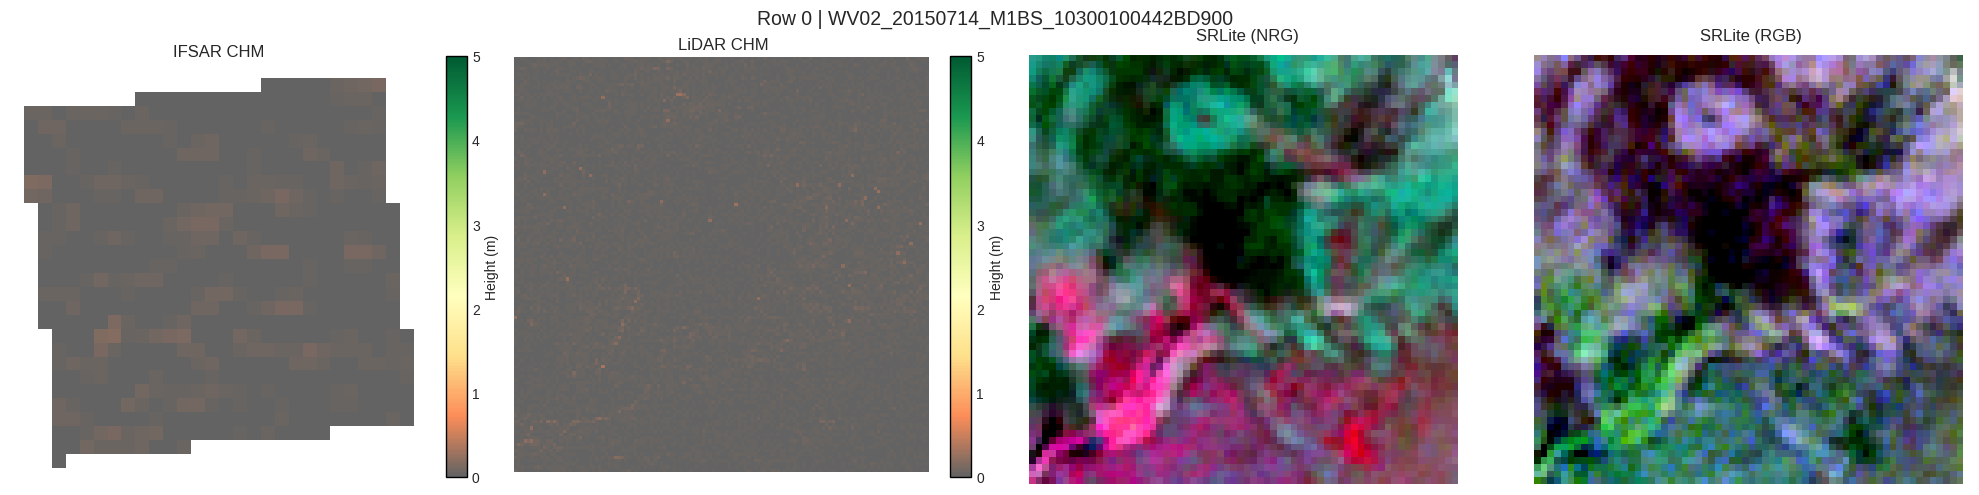


Row 1 | WV02_20150714_M1BS_10300100442BD900


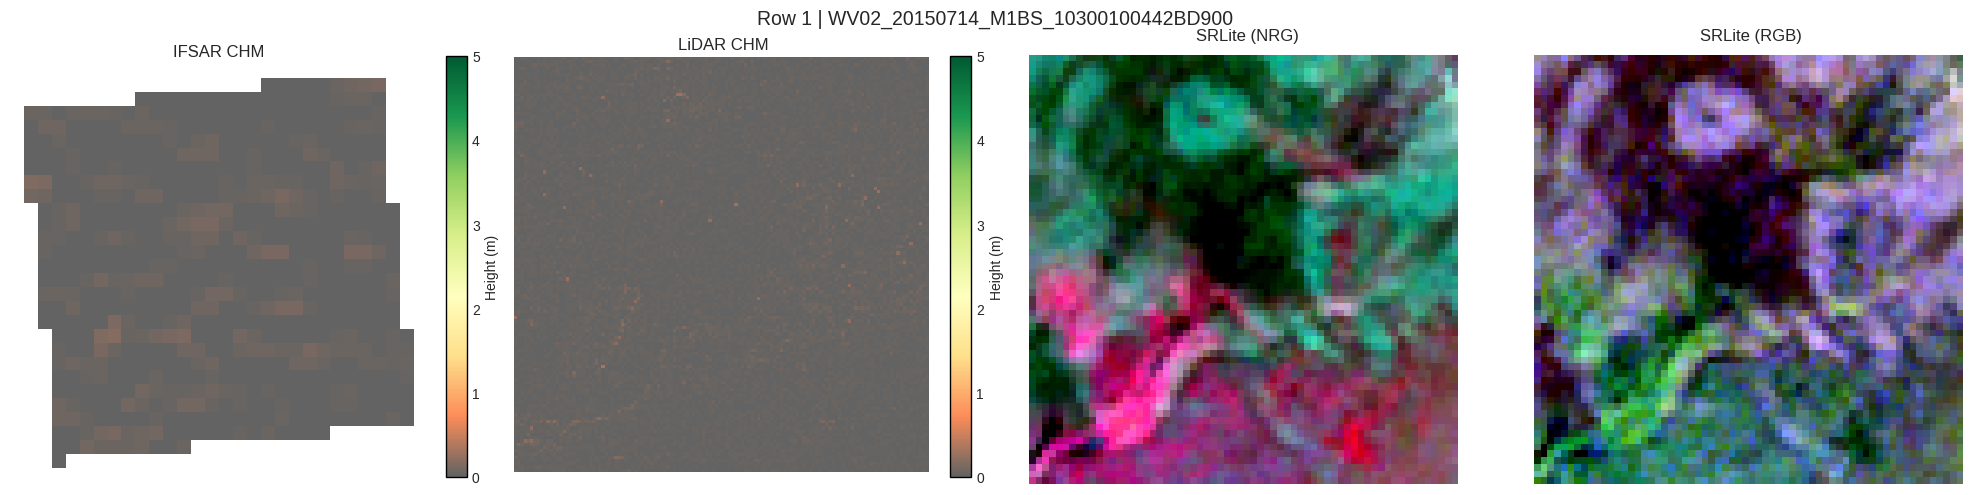


Row 2 | WV02_20150714_M1BS_10300100442BD900


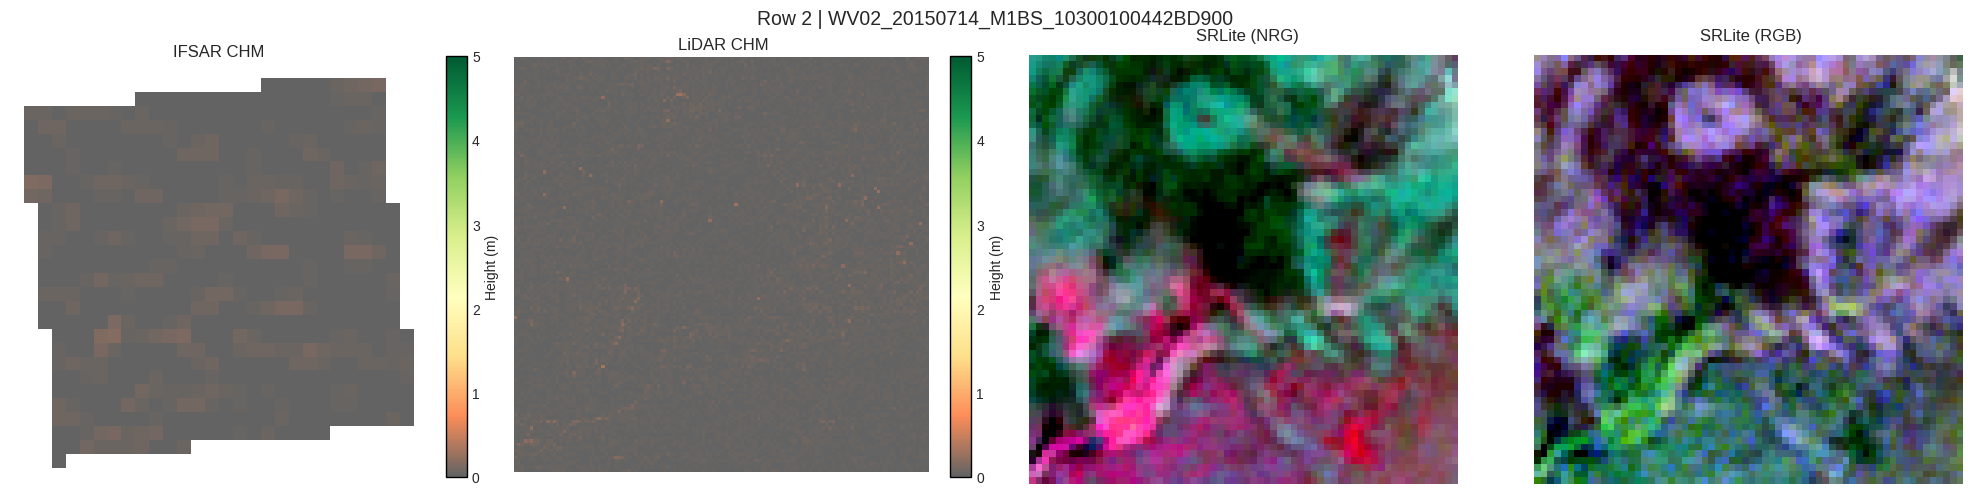


Row 3 | WV02_20150714_M1BS_10300100442BD900


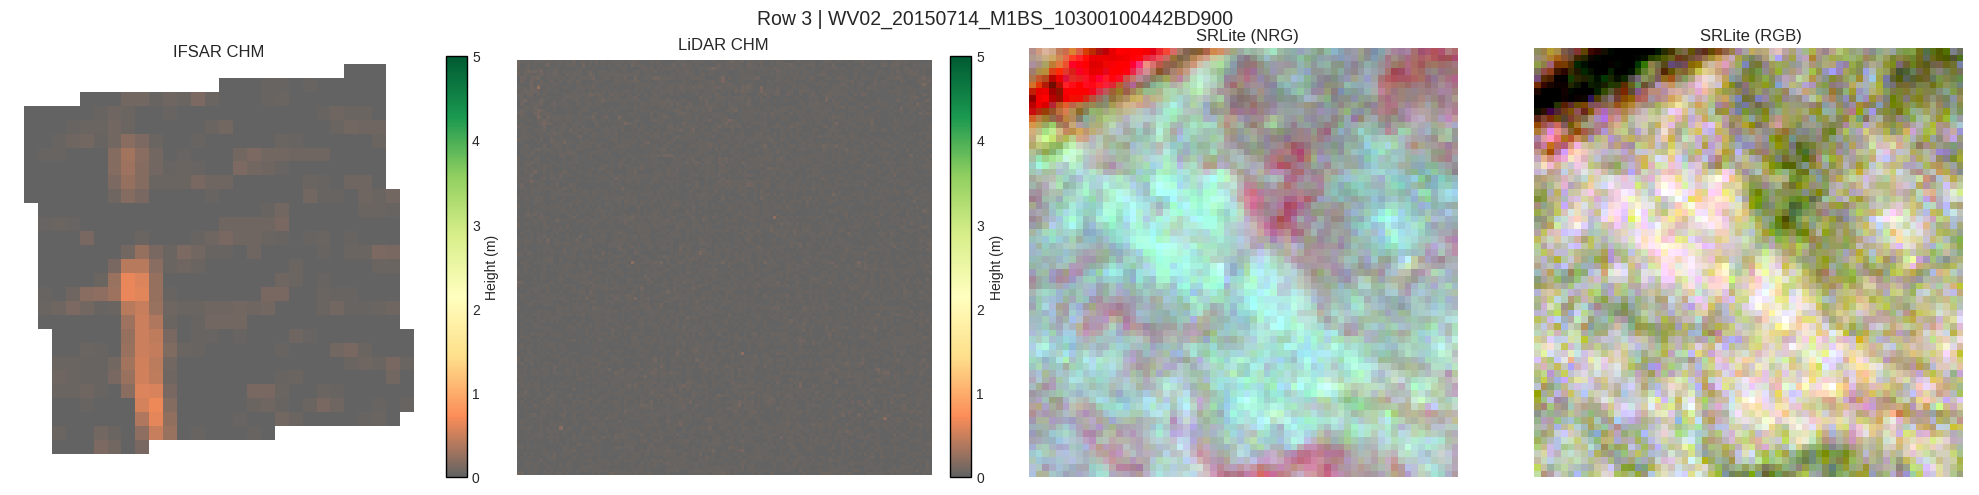


Row 4 | WV02_20150714_M1BS_10300100442BD900


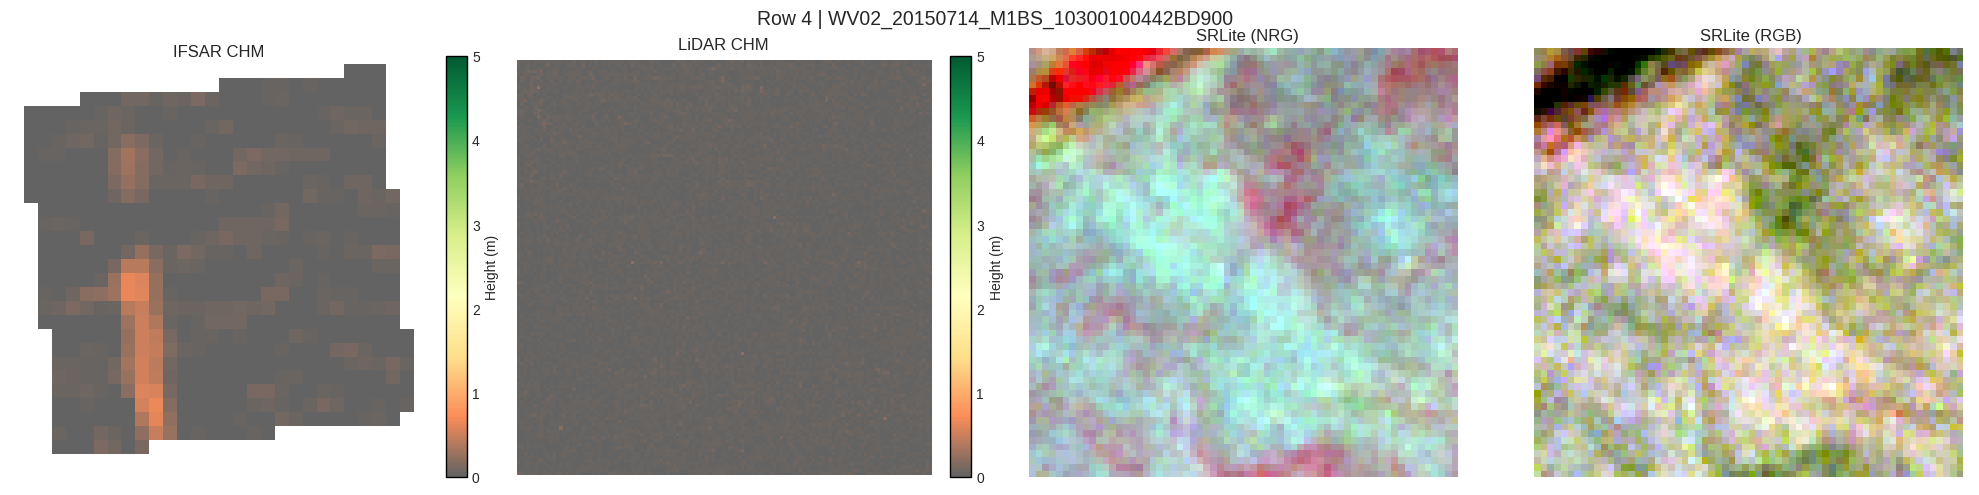


Row 5 | WV02_20150714_M1BS_10300100442BD900


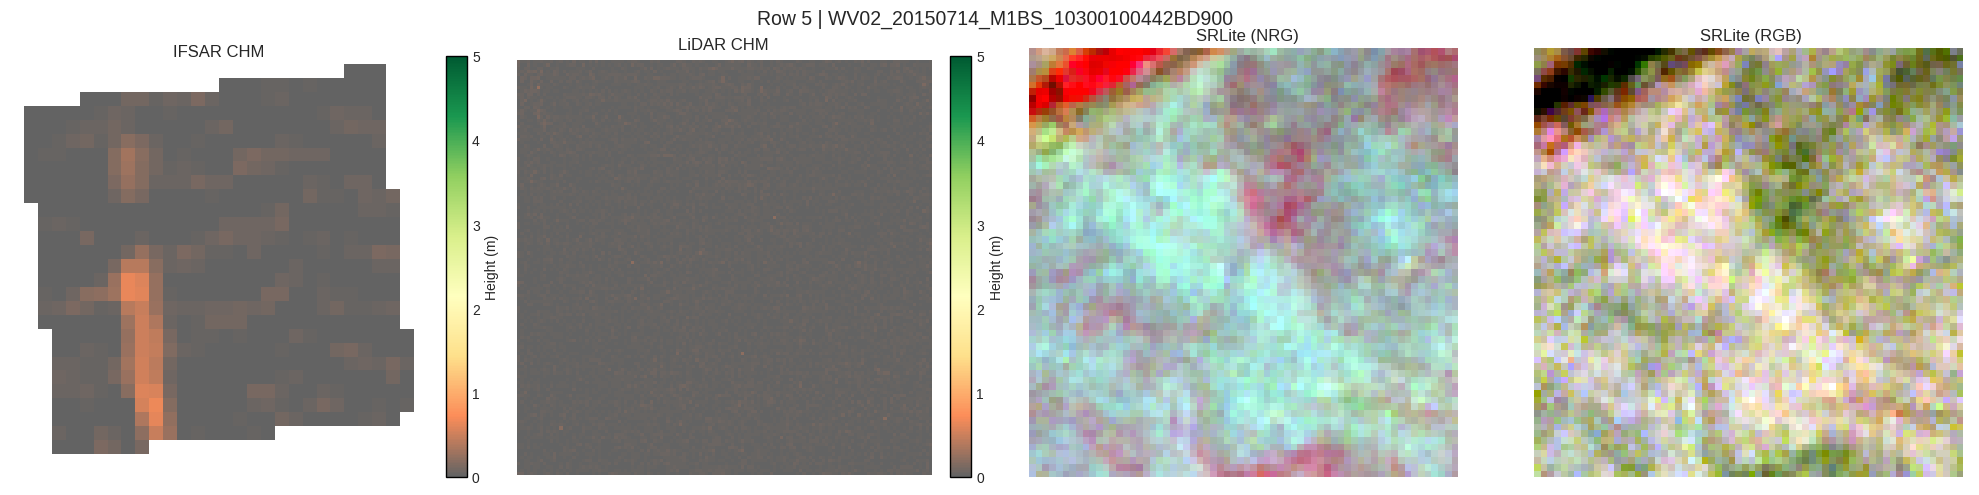


Row 6 | WV02_20150714_M1BS_10300100442BD900


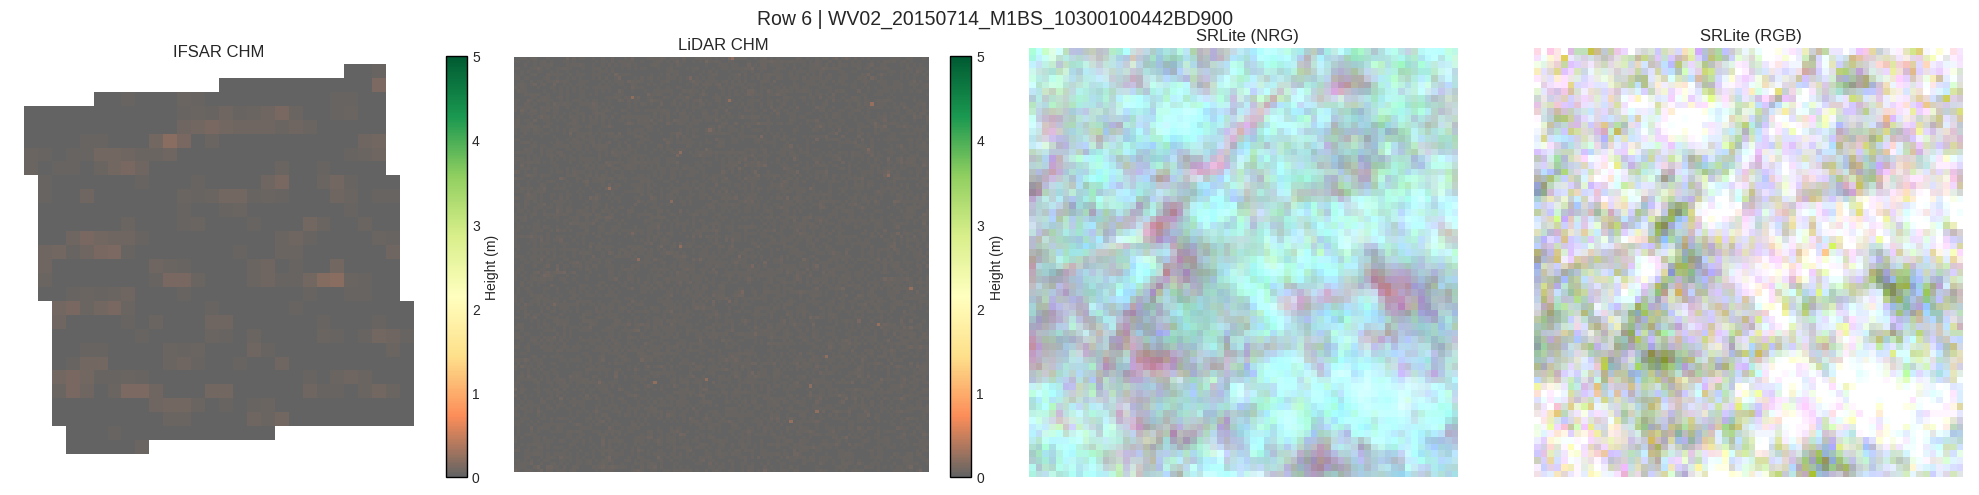


Row 7 | WV02_20150714_M1BS_10300100442BD900


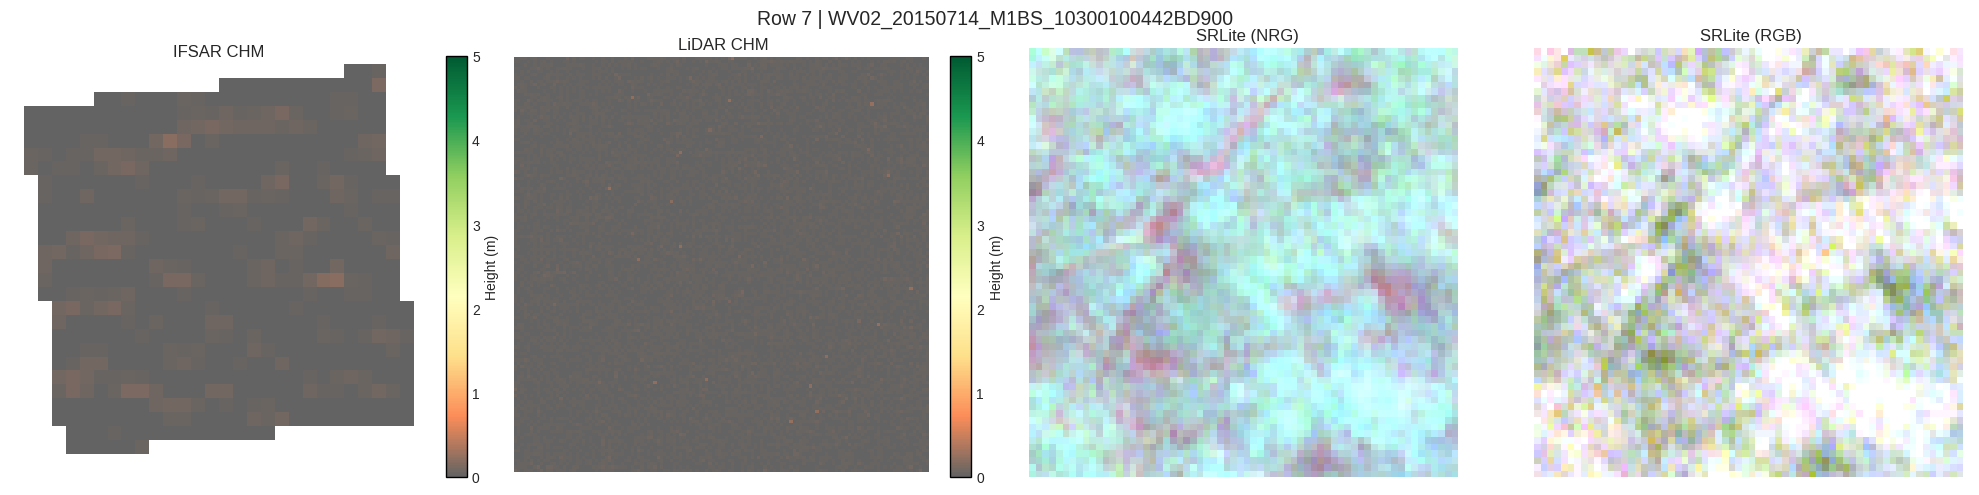


Row 8 | WV02_20150714_M1BS_10300100442BD900


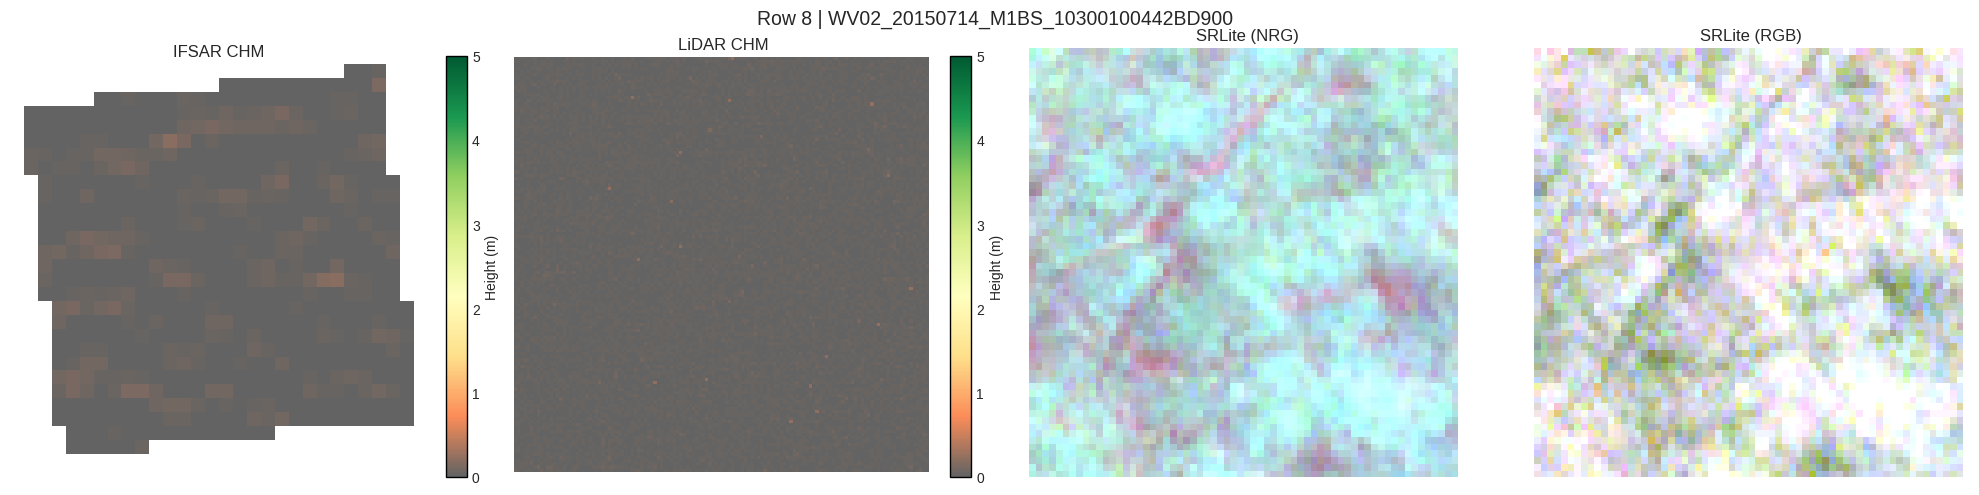


Row 9 | WV02_20150714_M1BS_10300100442BD900


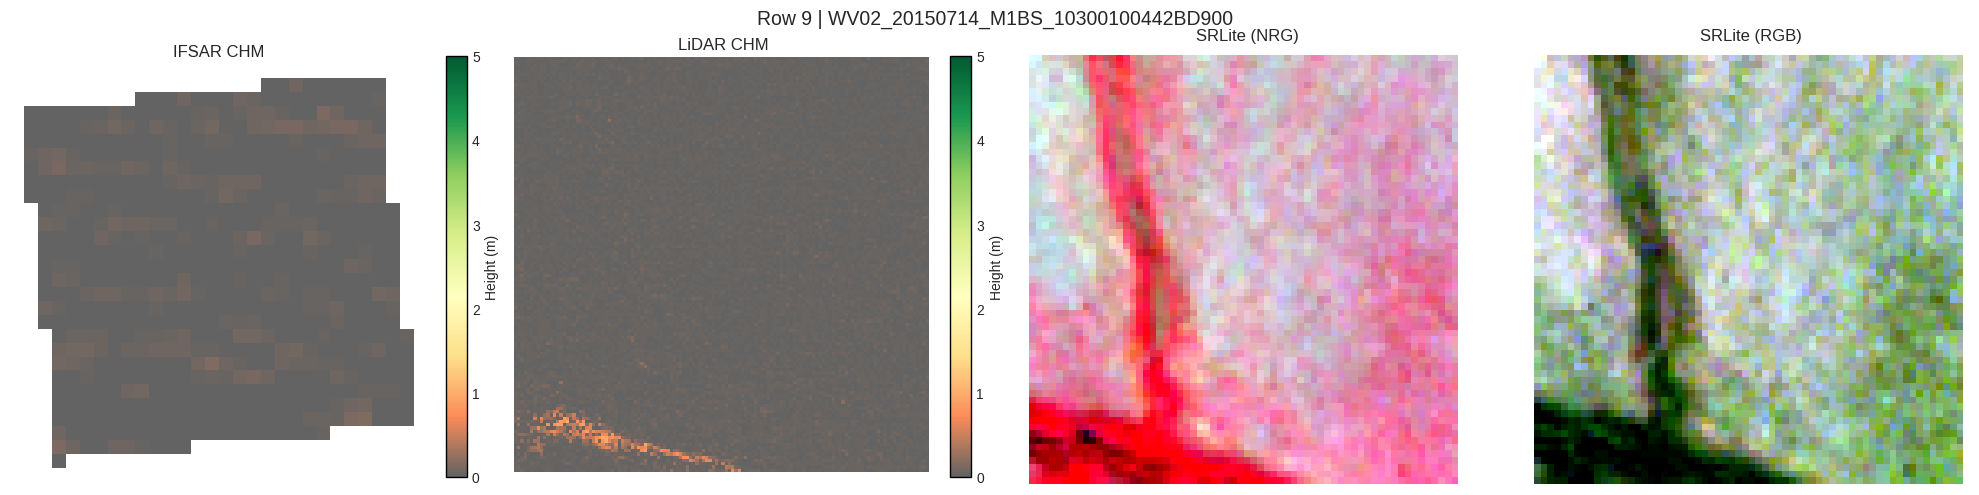


Row 10 | WV02_20150714_M1BS_10300100442BD900


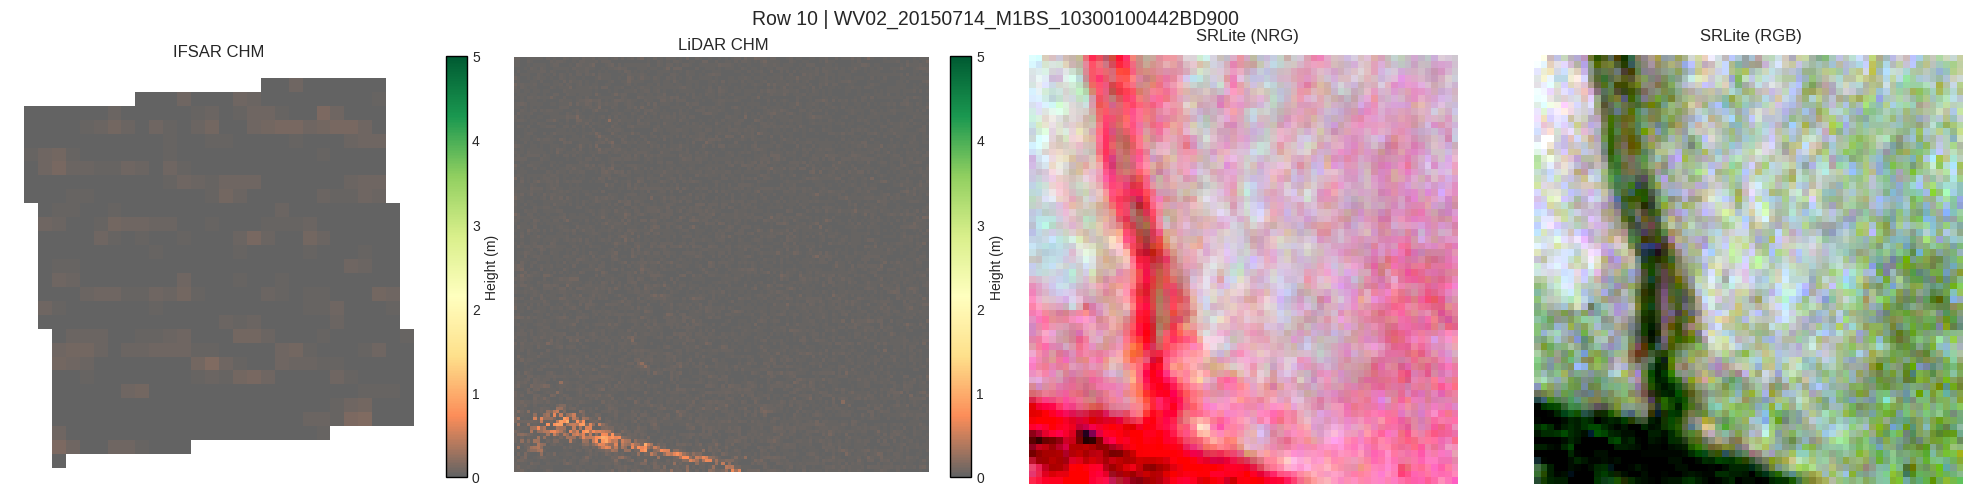


Row 11 | WV02_20150714_M1BS_10300100442BD900


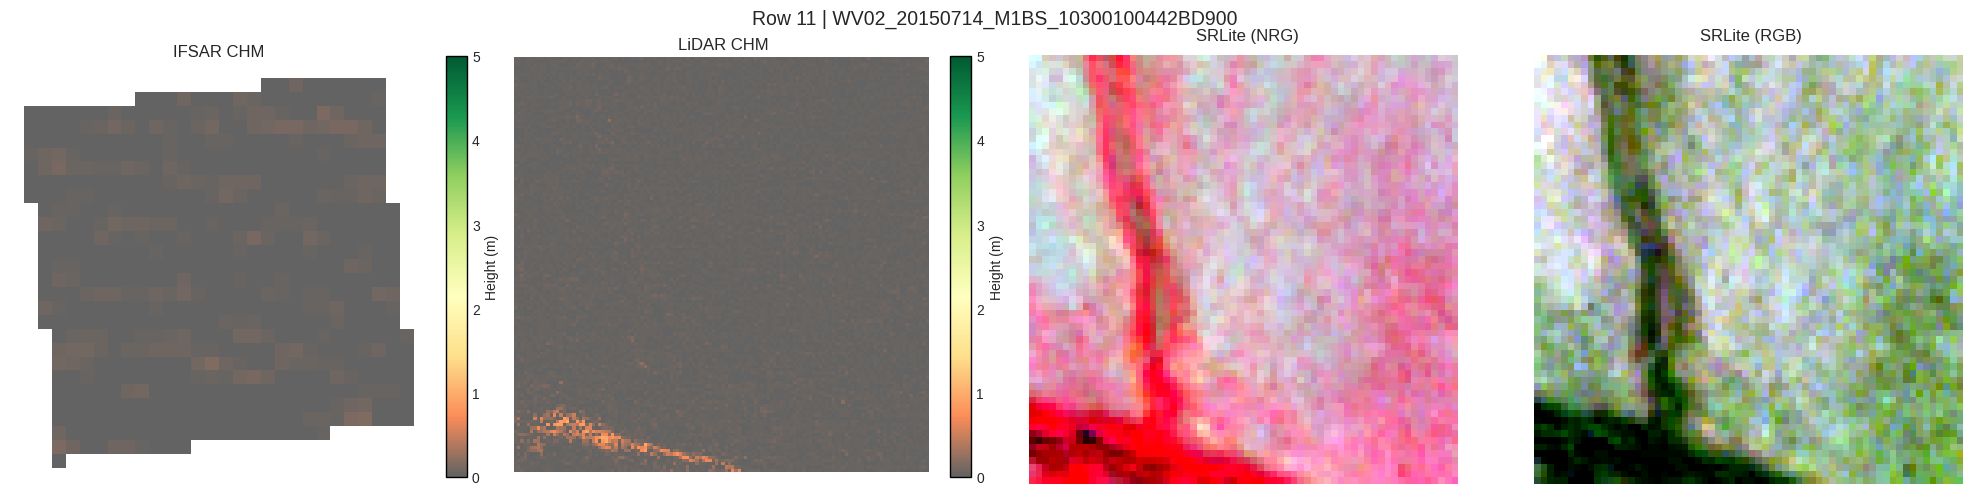


Row 12 | WV02_20150714_M1BS_10300100442BD900


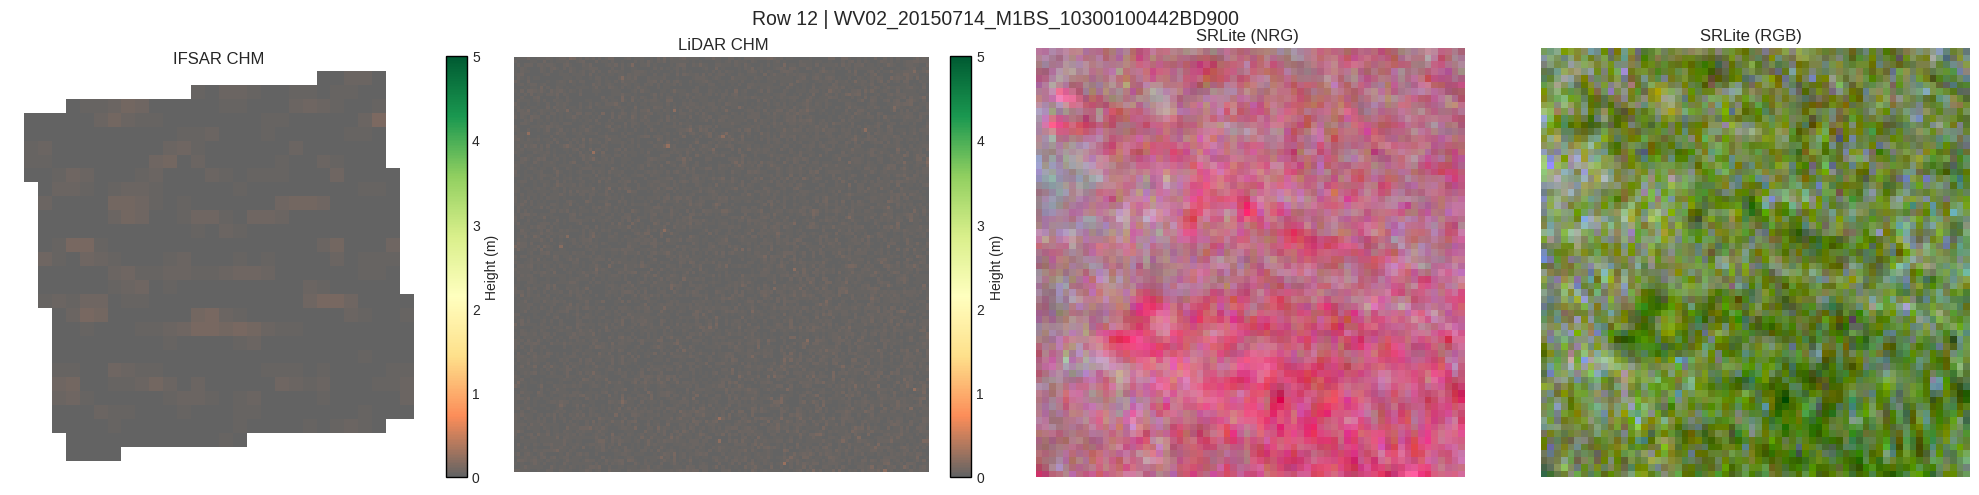


Row 13 | WV02_20150714_M1BS_10300100442BD900


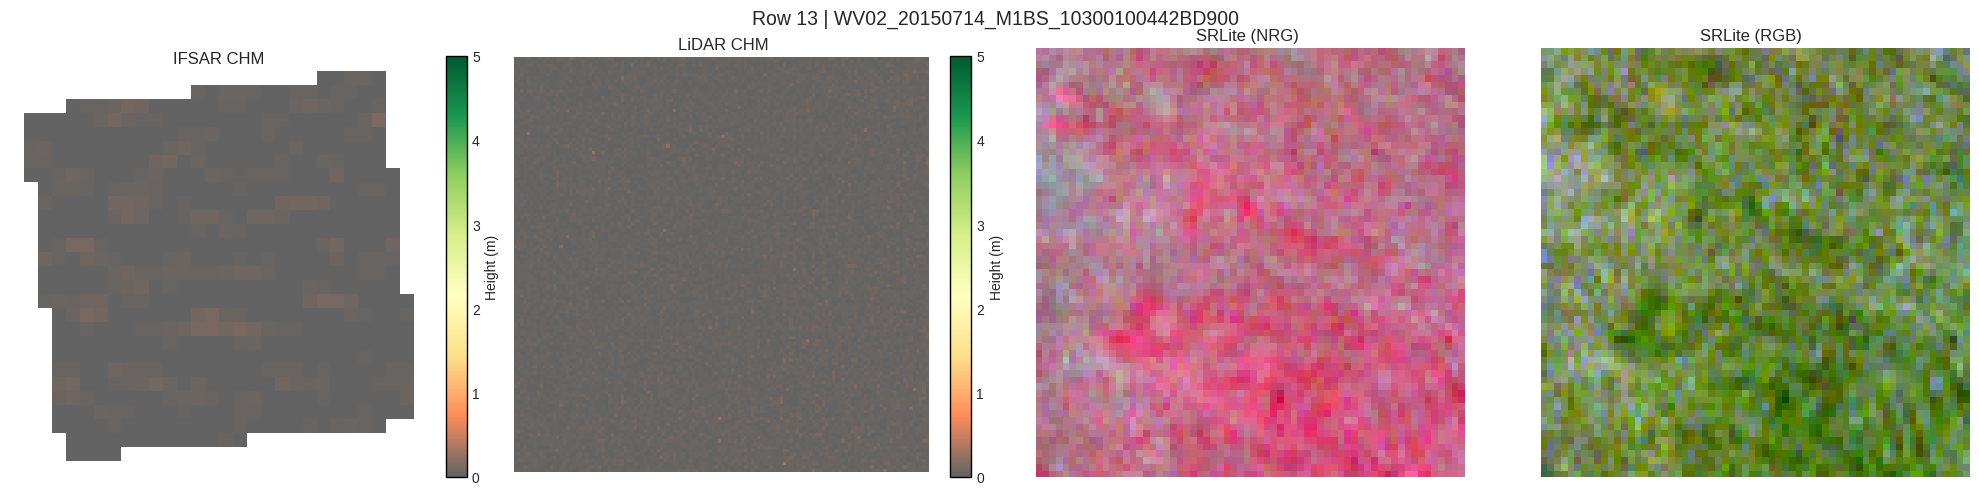


Row 14 | WV02_20150714_M1BS_10300100442BD900


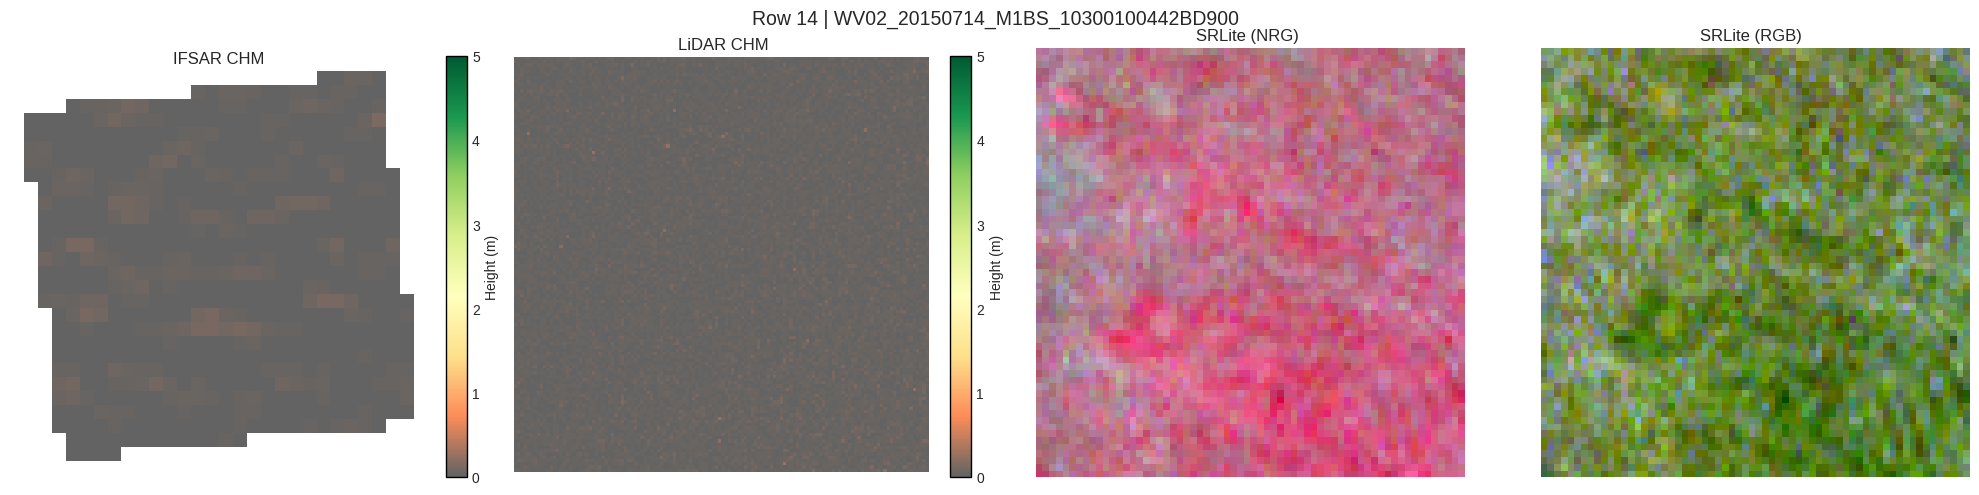


Row 15 | WV02_20150714_M1BS_10300100442BD900


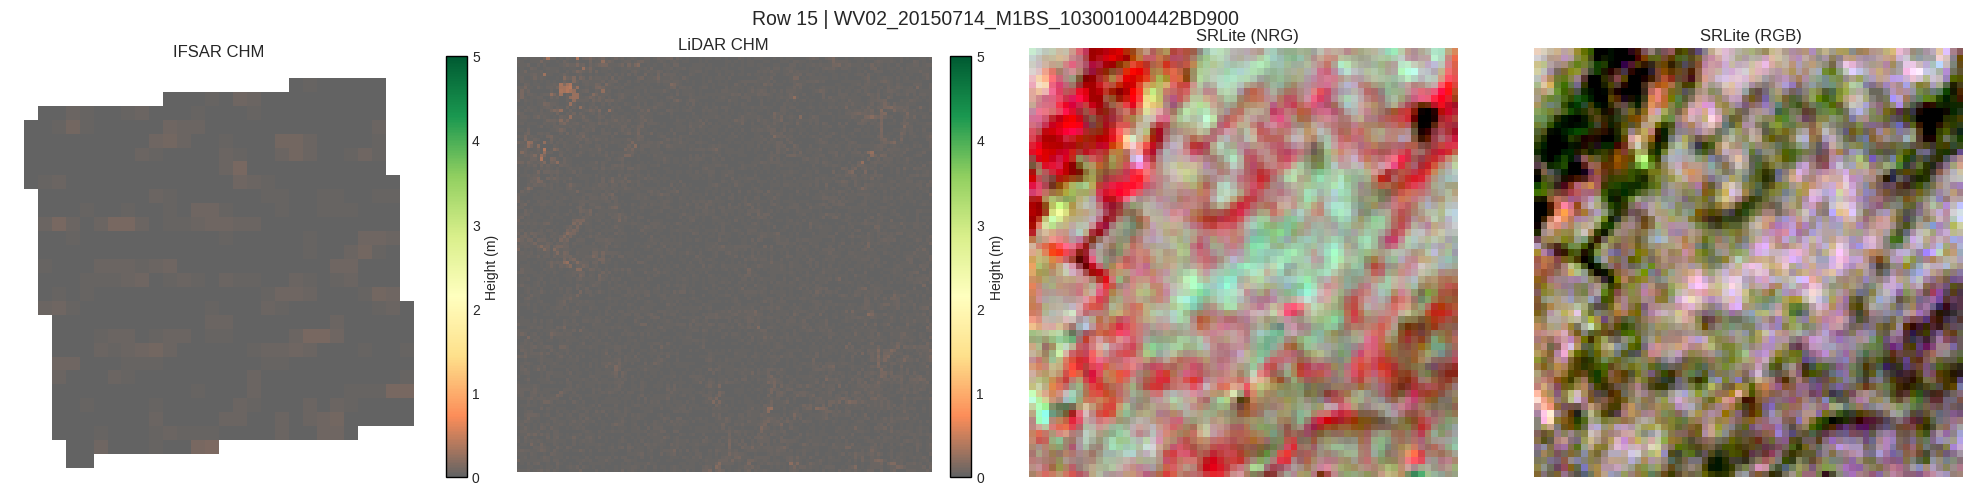


Row 16 | WV02_20150714_M1BS_10300100442BD900


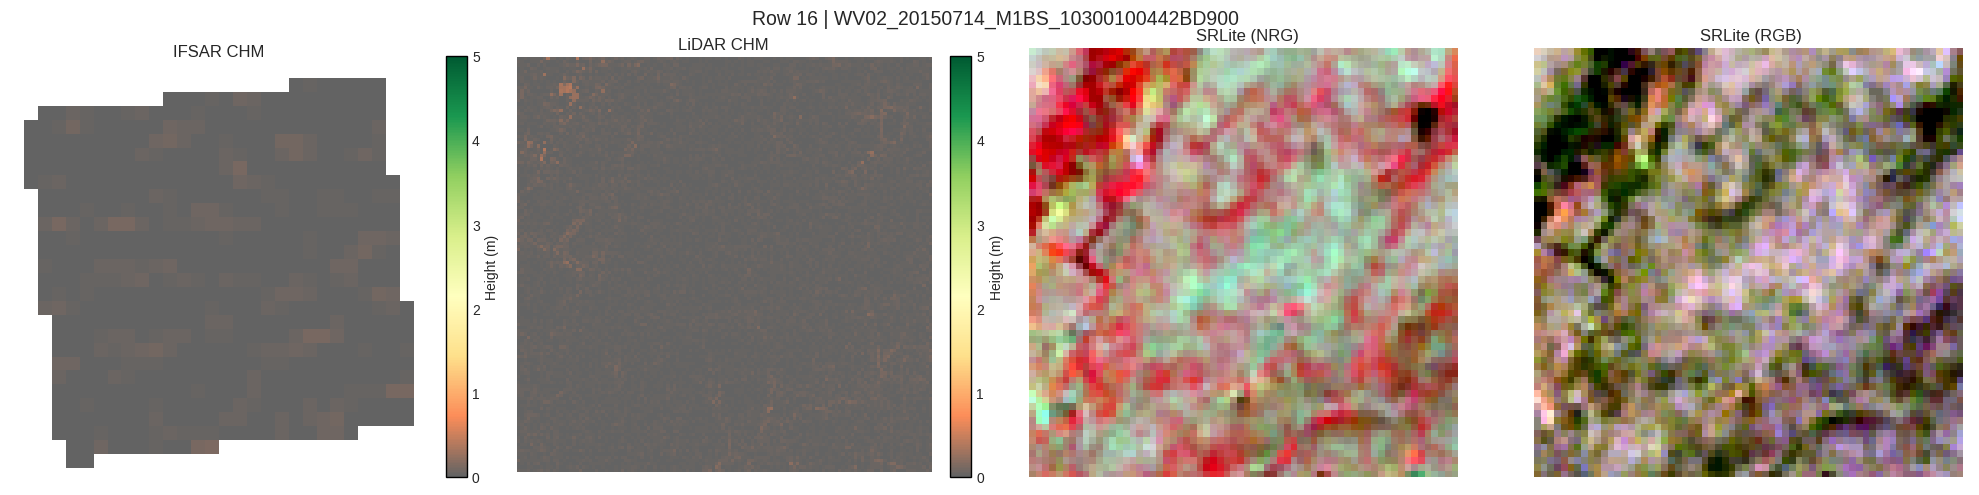


Row 17 | WV02_20150714_M1BS_10300100442BD900


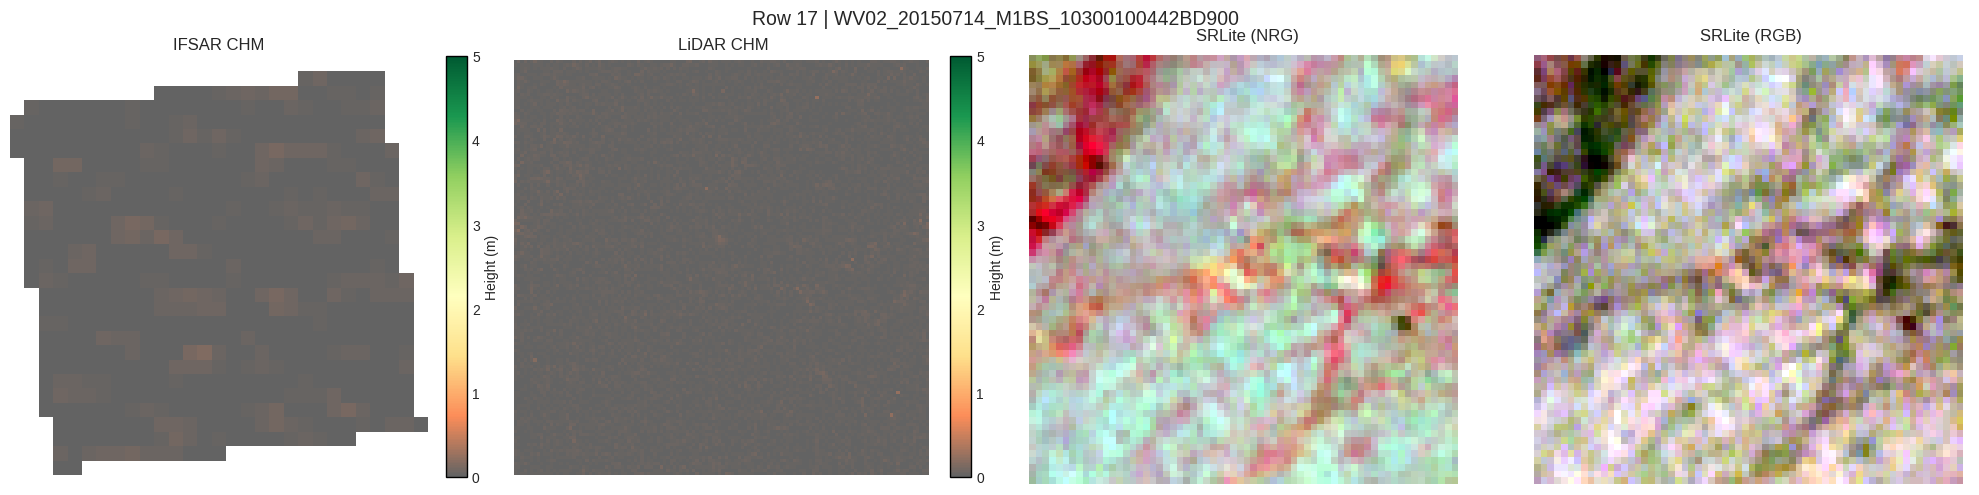


Row 18 | WV02_20150714_M1BS_10300100442BD900


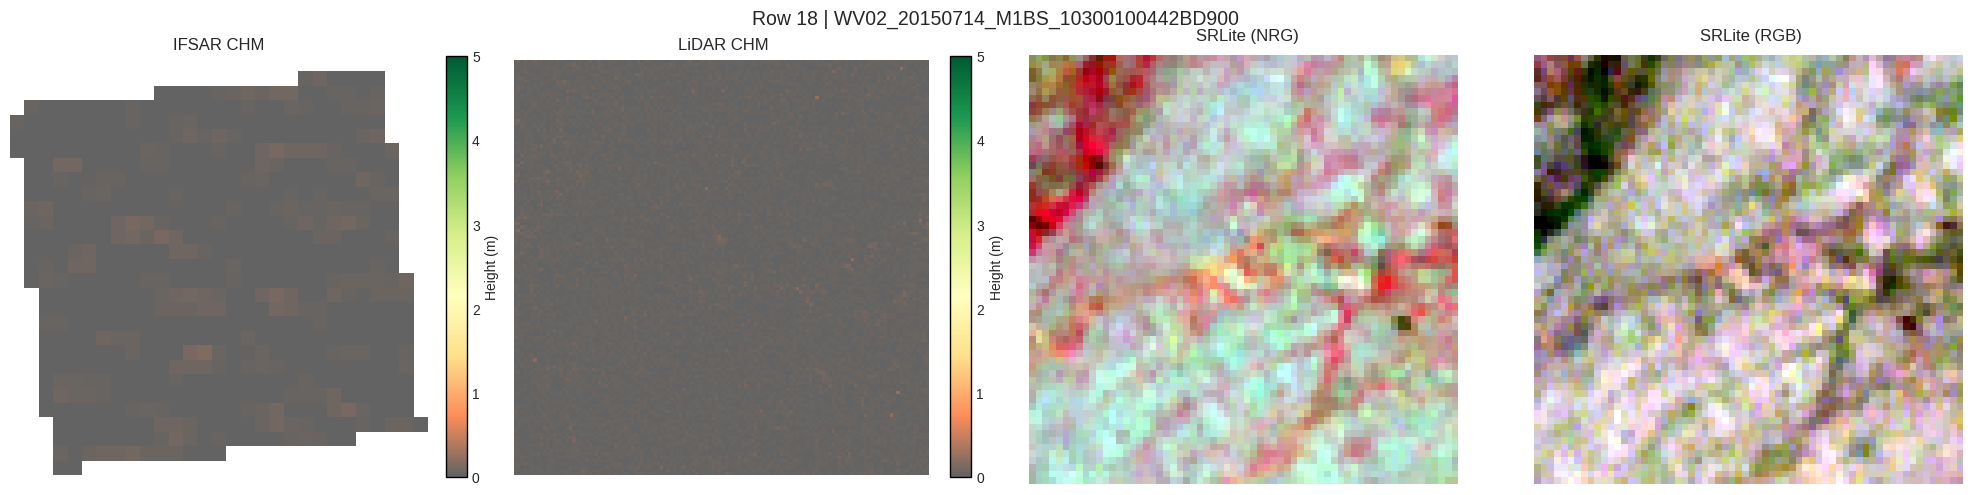


Row 19 | WV02_20150714_M1BS_10300100442BD900


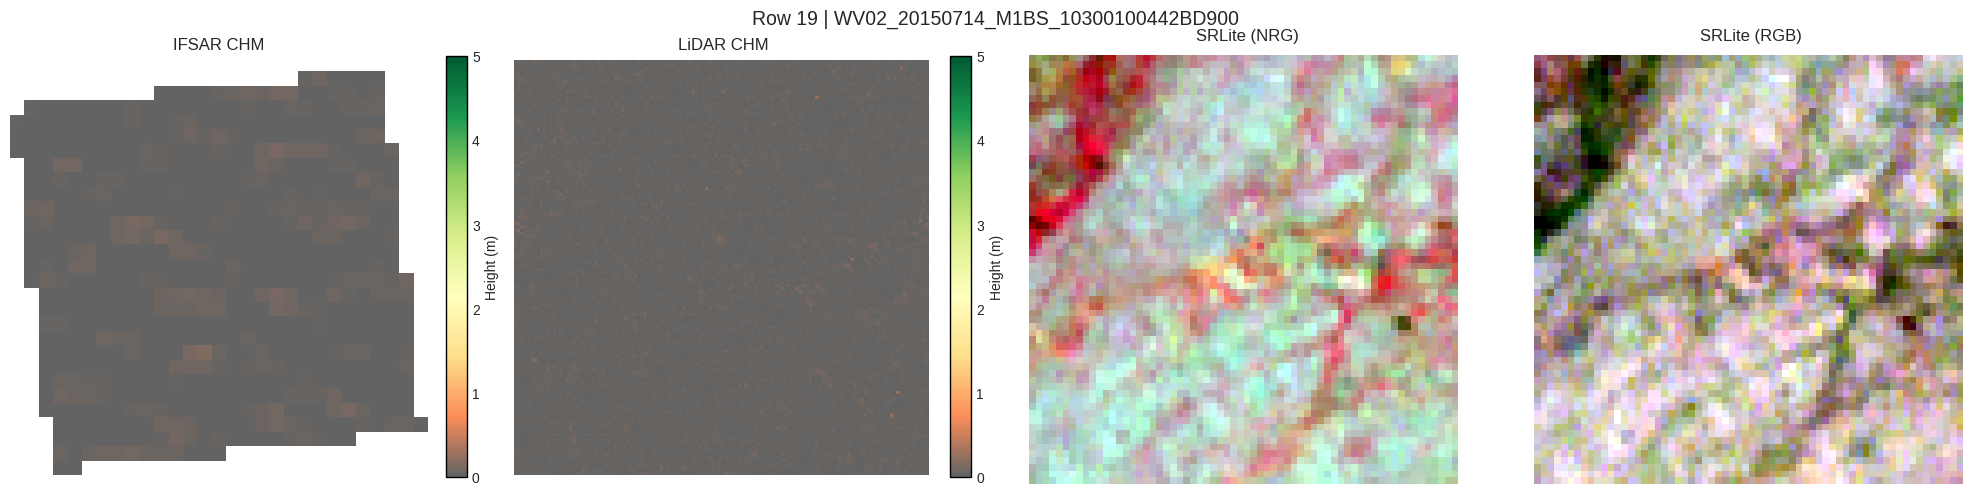


Row 20 | WV02_20150714_M1BS_10300100442BD900


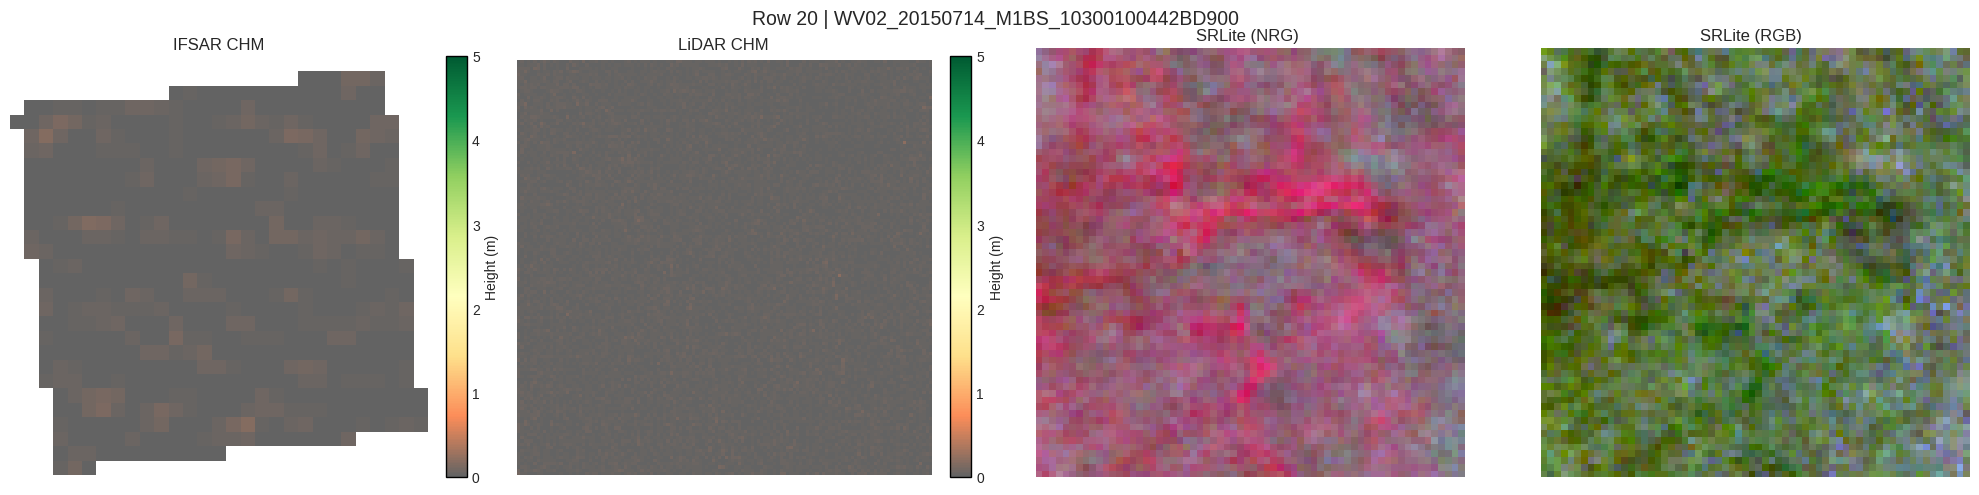


Row 21 | WV02_20150714_M1BS_10300100442BD900


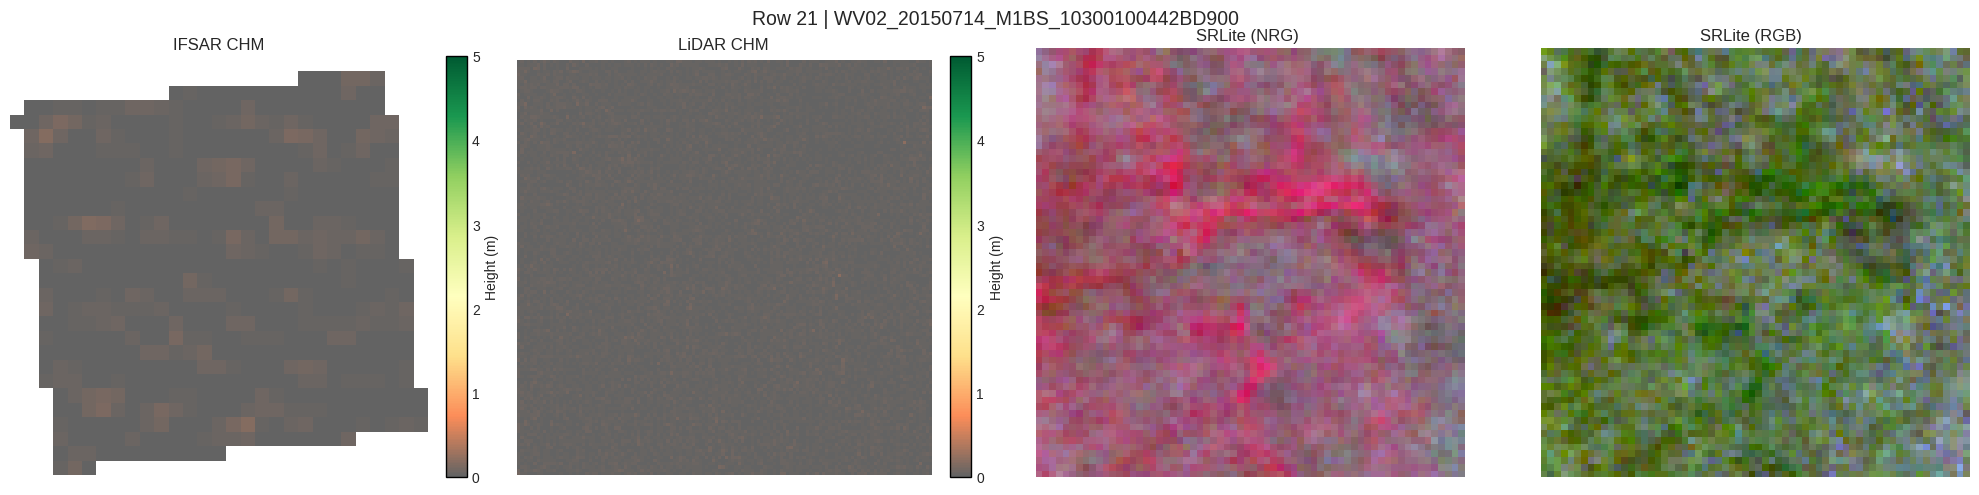


Row 22 | WV02_20150714_M1BS_10300100442BD900


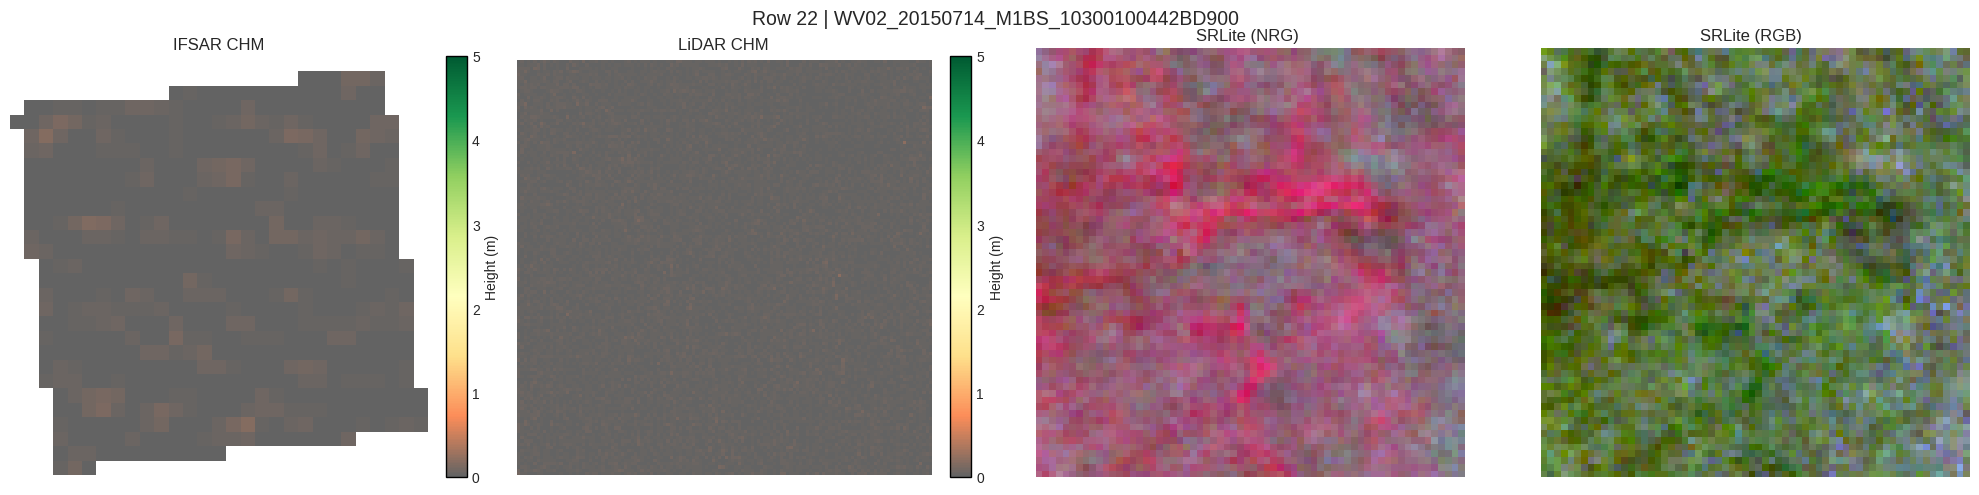


Row 23 | WV02_20150714_M1BS_10300100442BD900


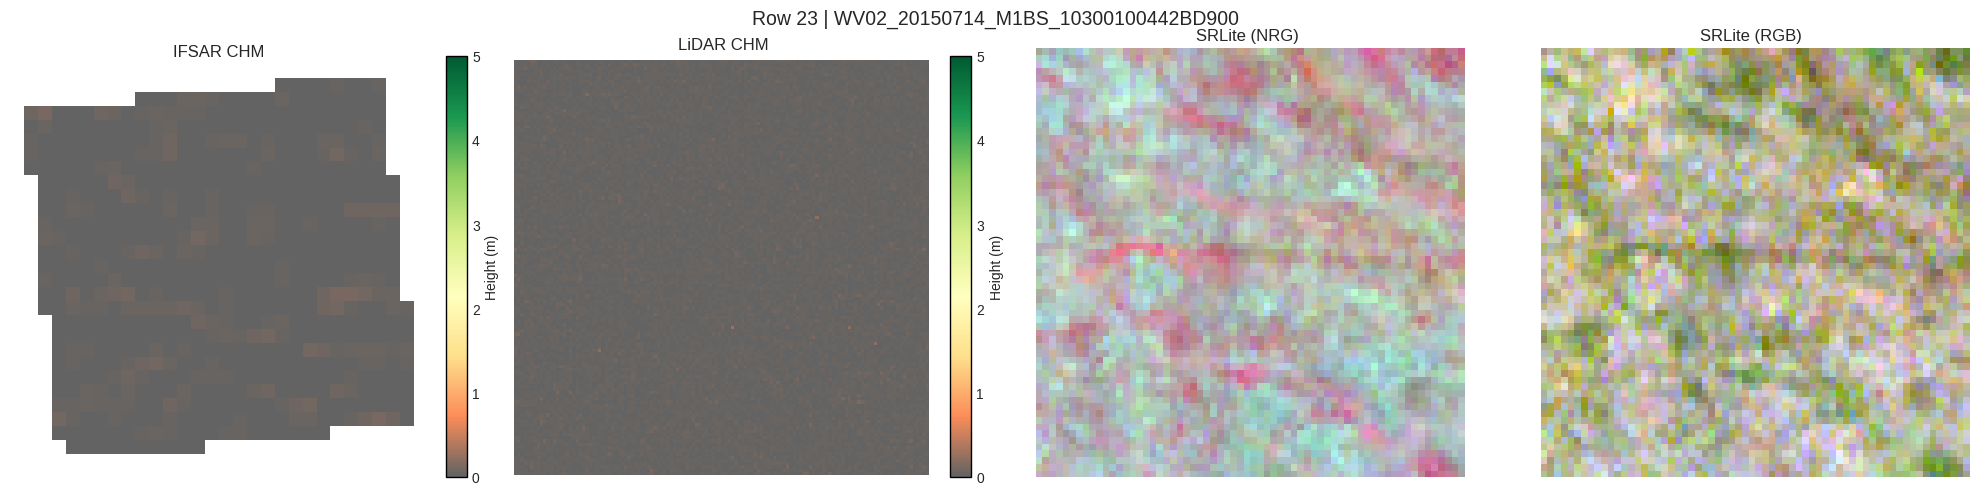


Row 24 | WV02_20150714_M1BS_10300100442BD900


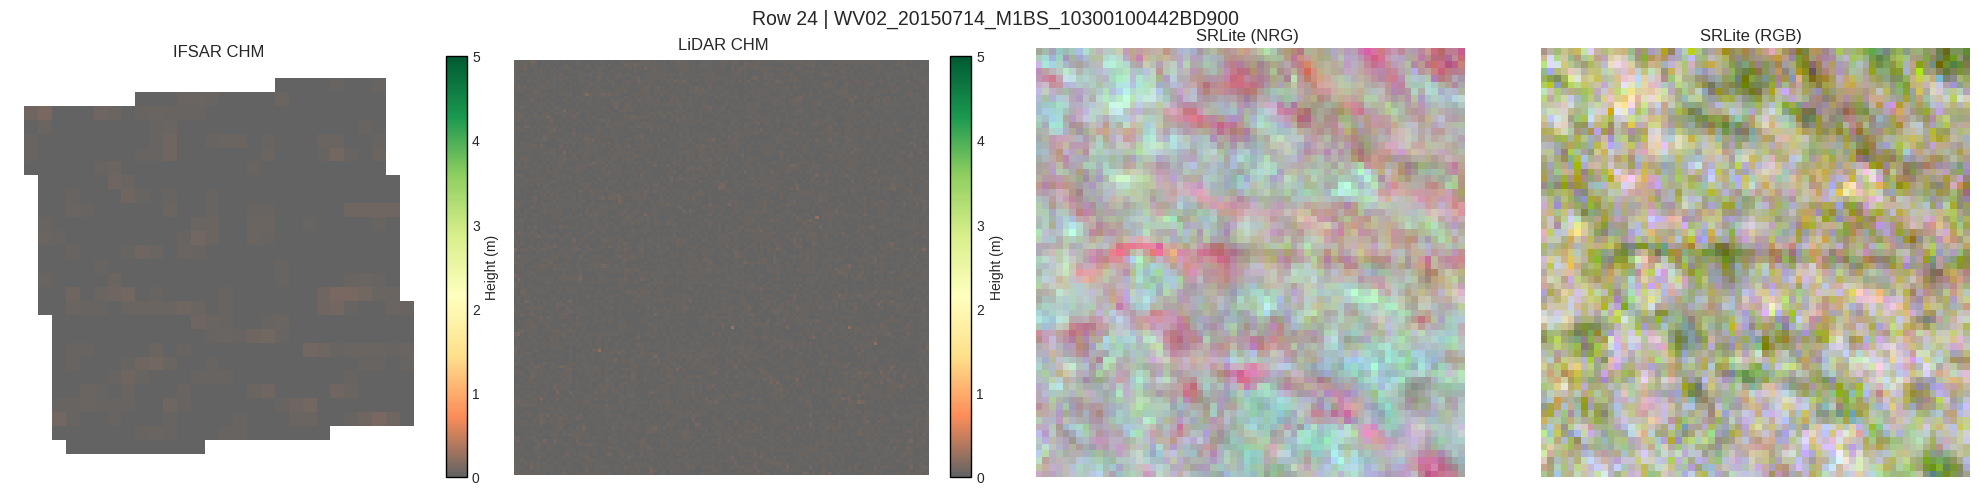


Row 25 | WV02_20150714_M1BS_10300100442BD900


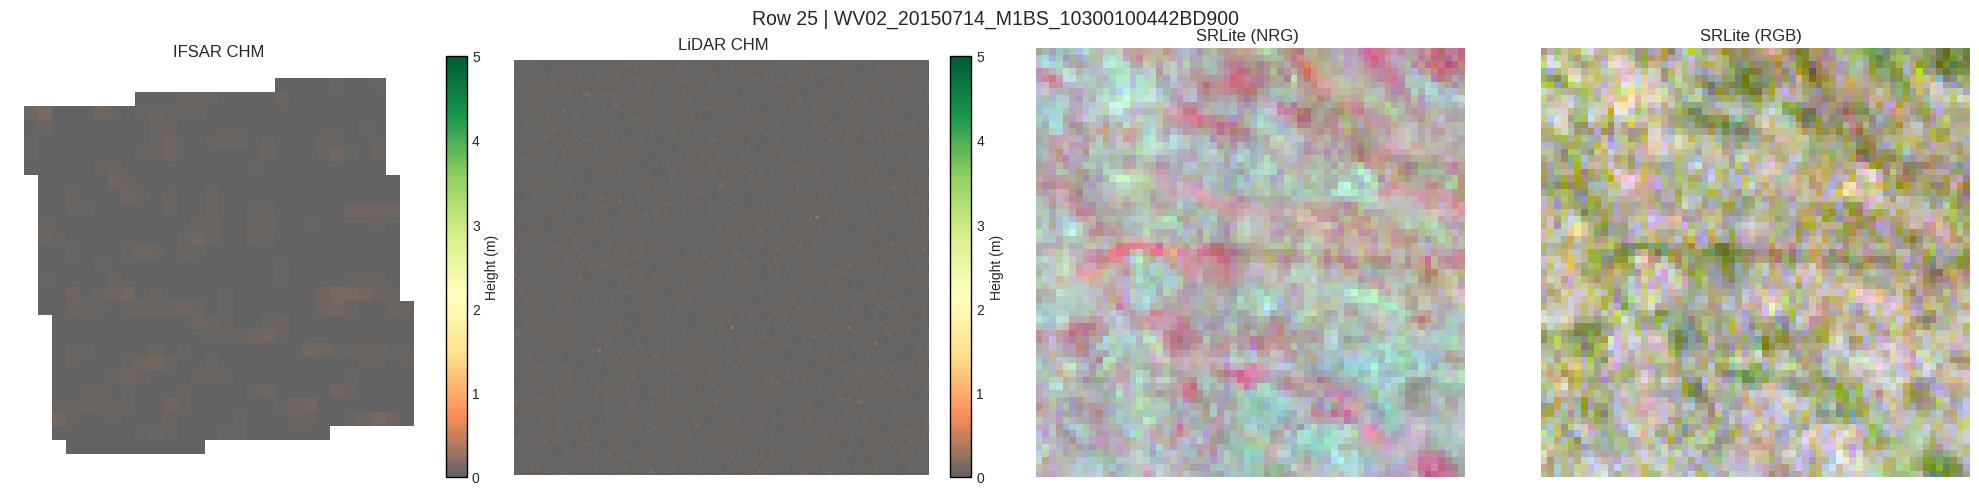


Row 26 | WV02_20150714_M1BS_10300100442BD900


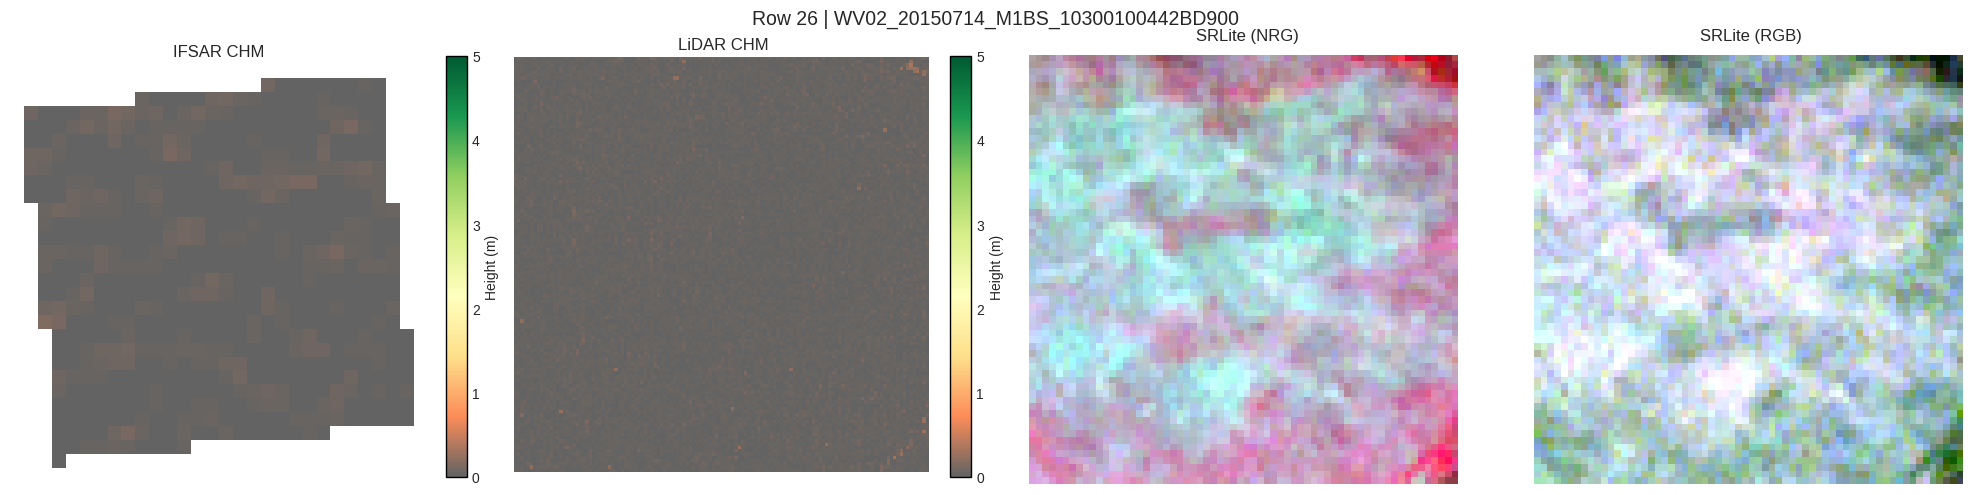


Row 27 | WV02_20150714_M1BS_10300100442BD900


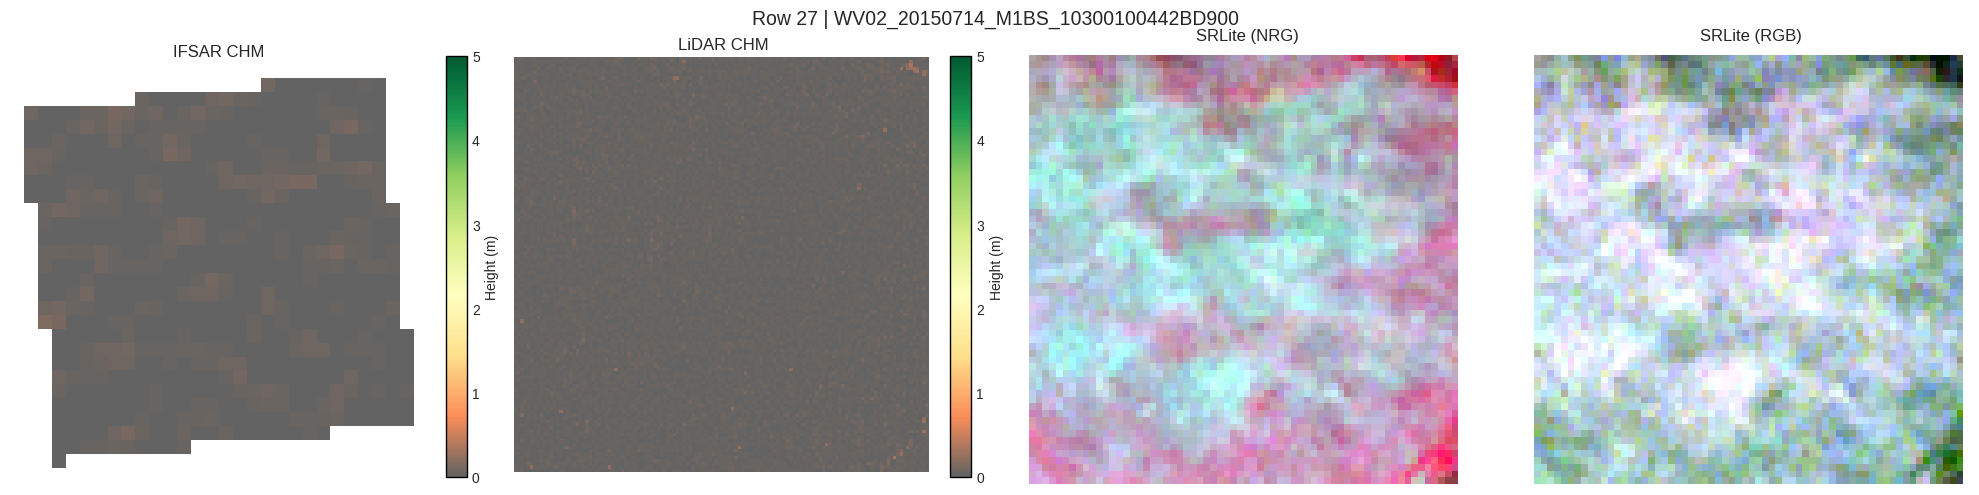


Row 28 | WV02_20150714_M1BS_10300100442BD900


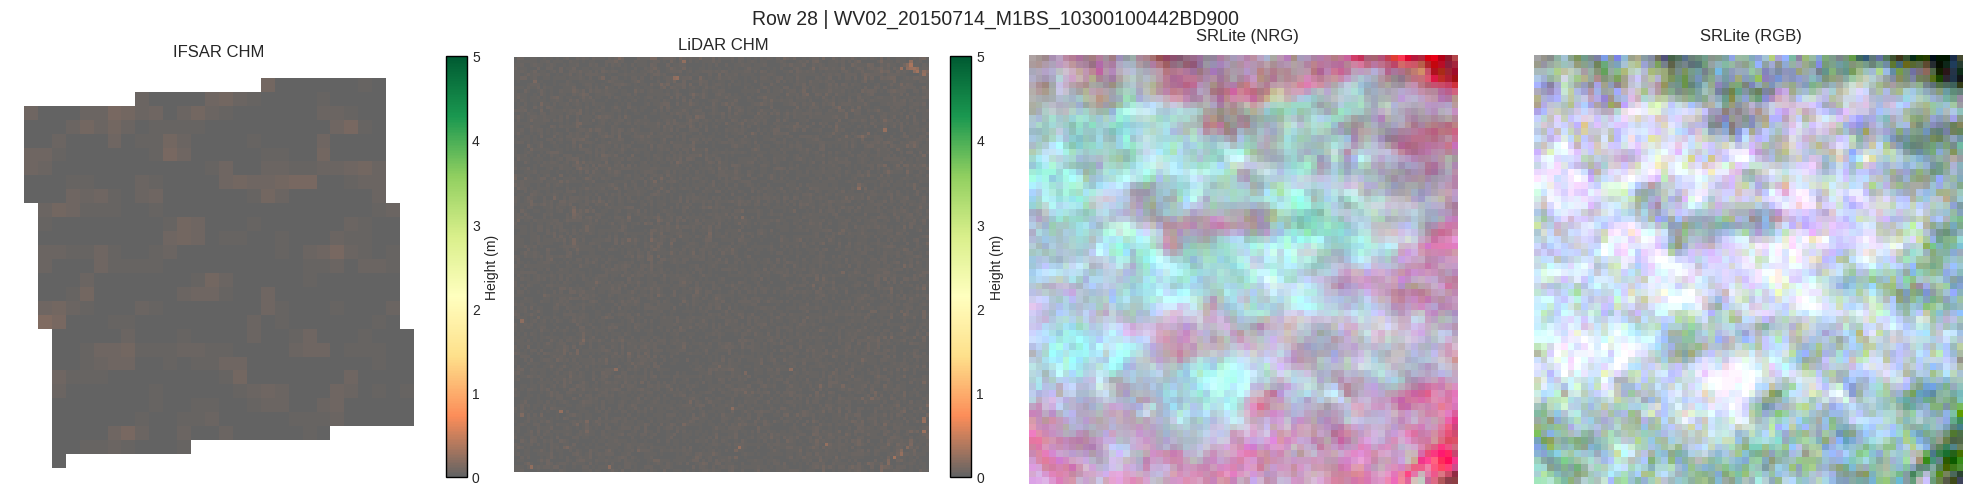


Row 29 | WV02_20150714_M1BS_10300100442BD900


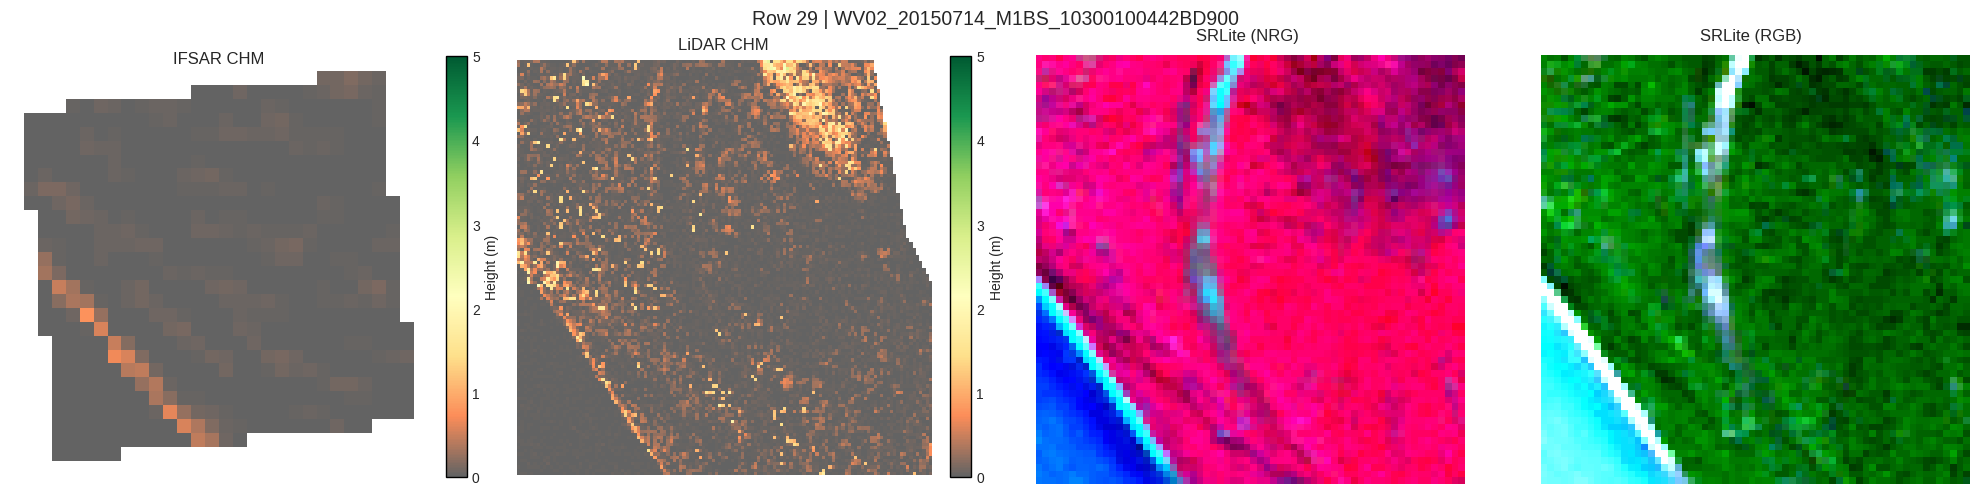


Row 30 | WV02_20150714_M1BS_10300100442BD900


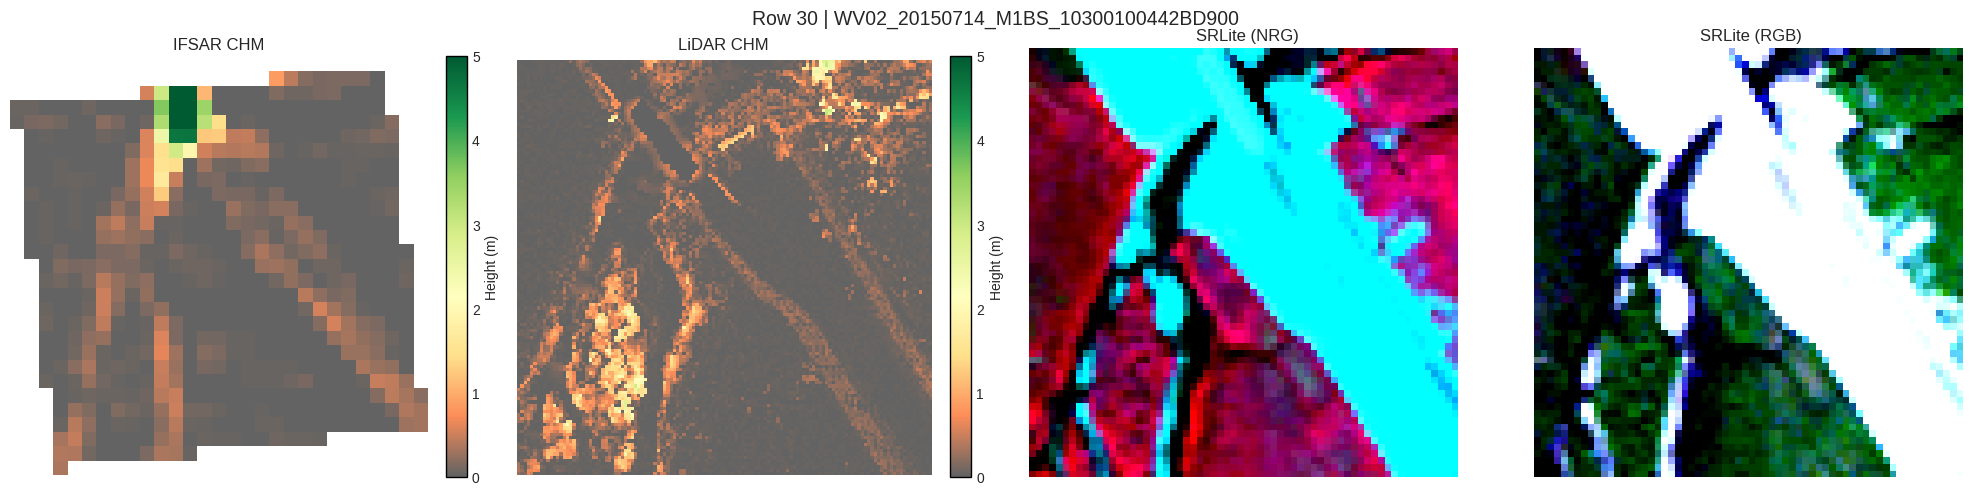


Row 31 | WV02_20150714_M1BS_10300100442BD900


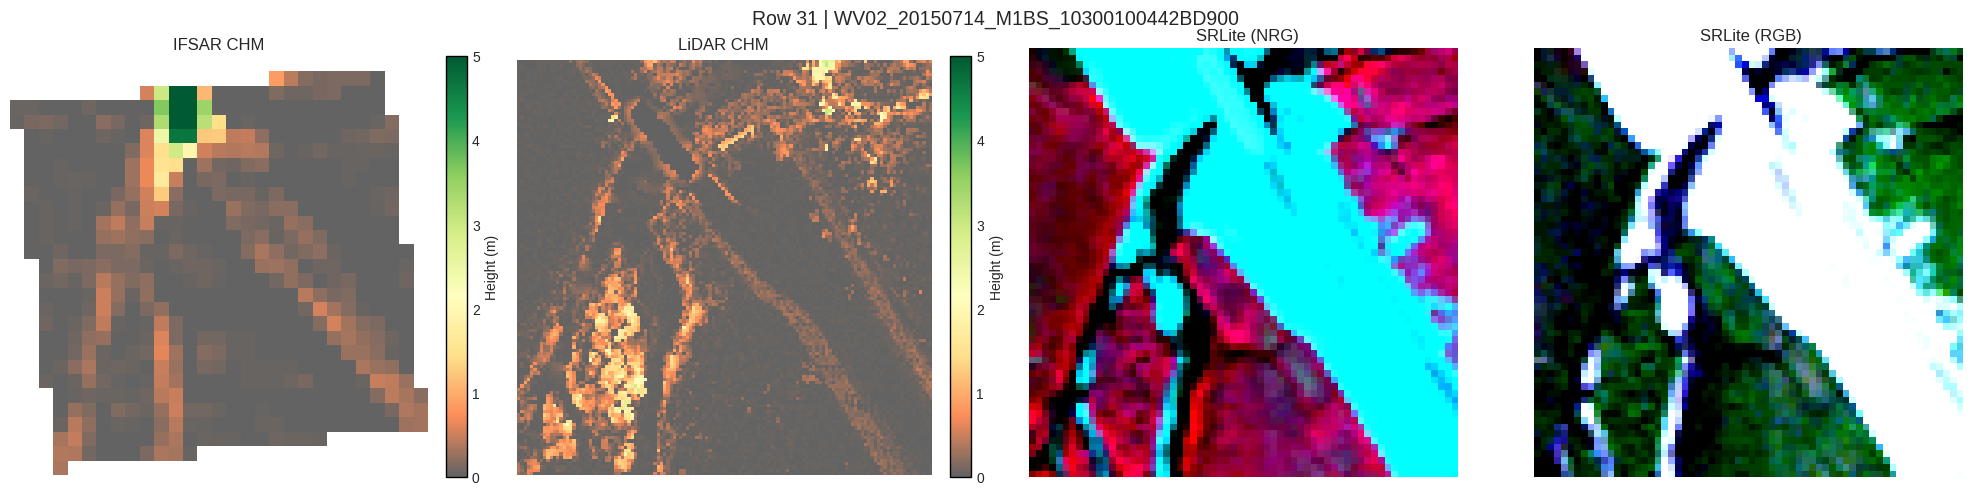


Row 32 | WV02_20150714_M1BS_10300100442BD900


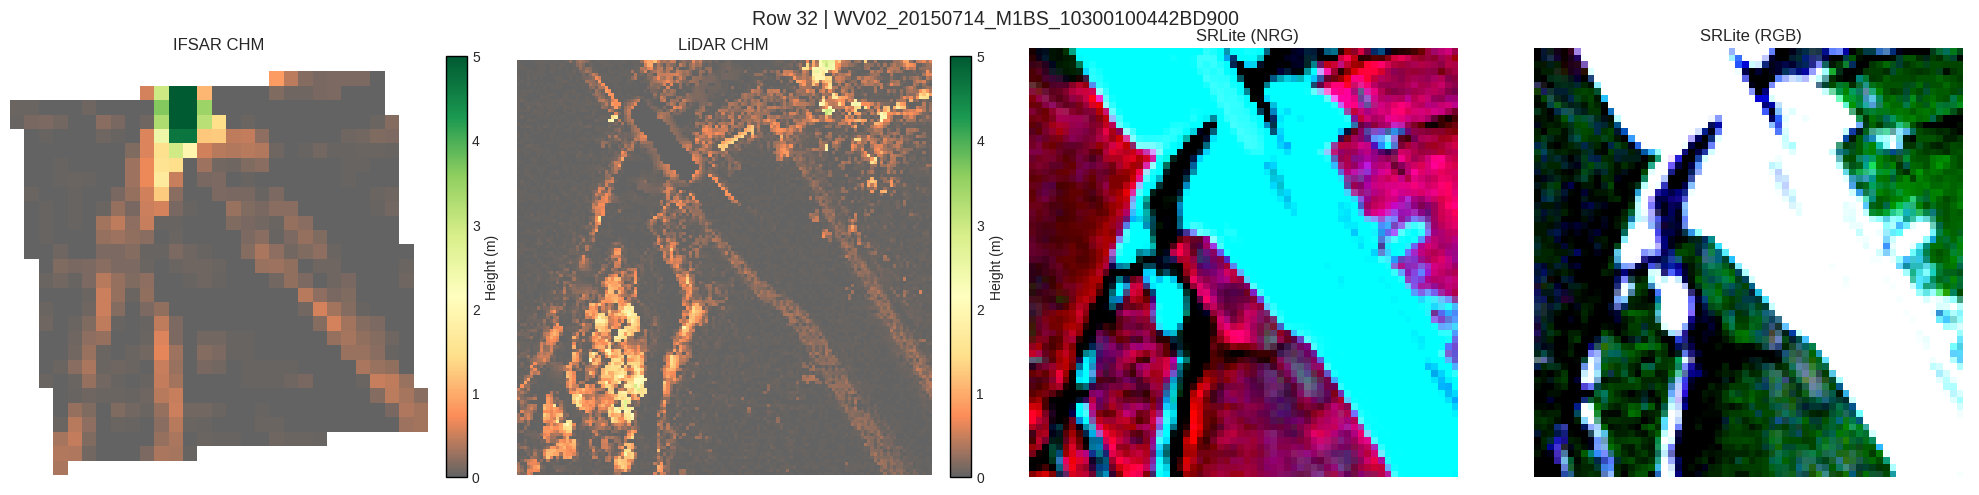


Row 33 | WV02_20150714_M1BS_10300100442BD900


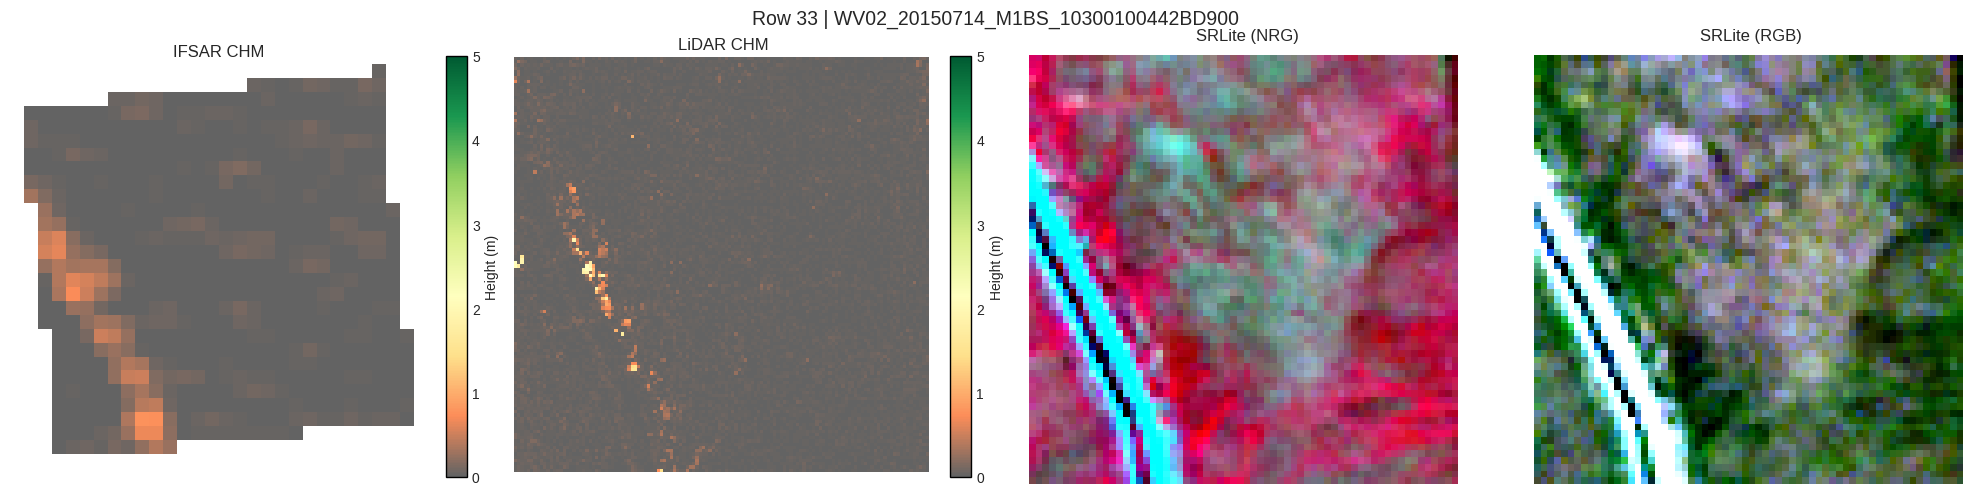


Row 34 | WV02_20150714_M1BS_10300100442BD900


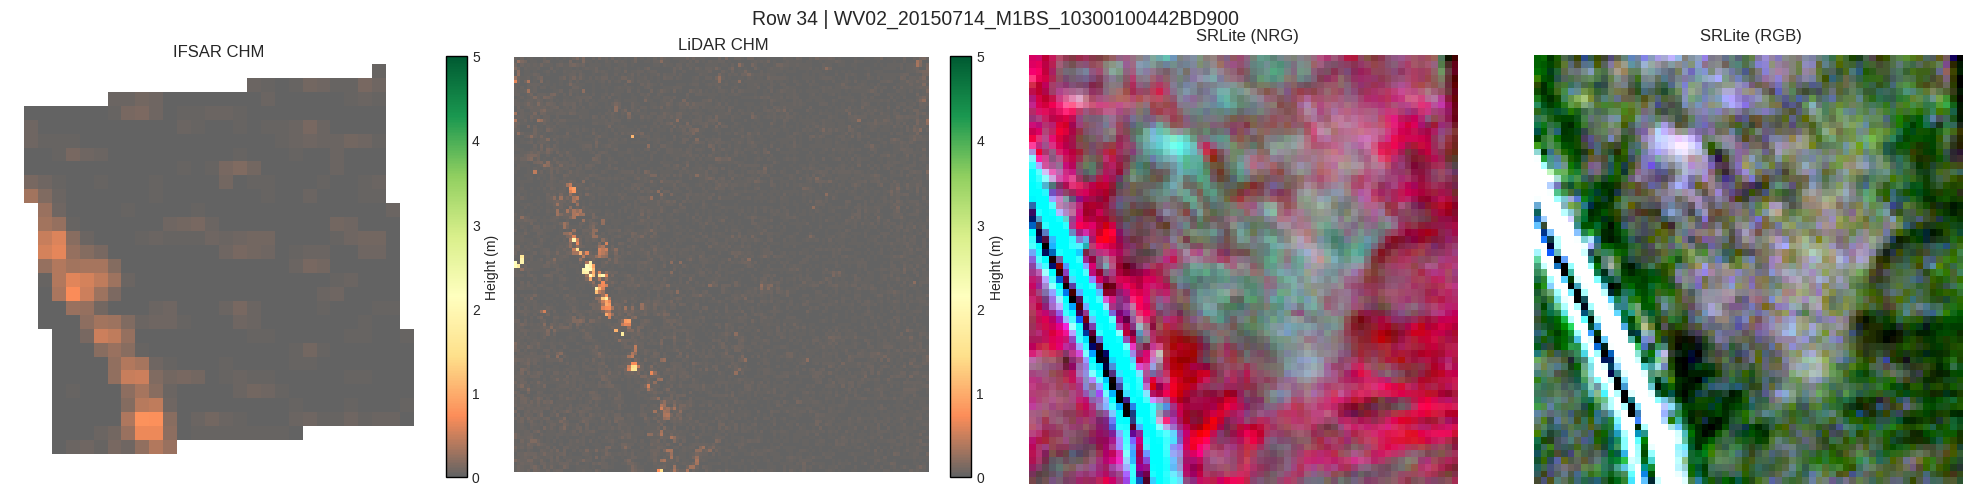


Row 35 | WV02_20150714_M1BS_10300100442BD900


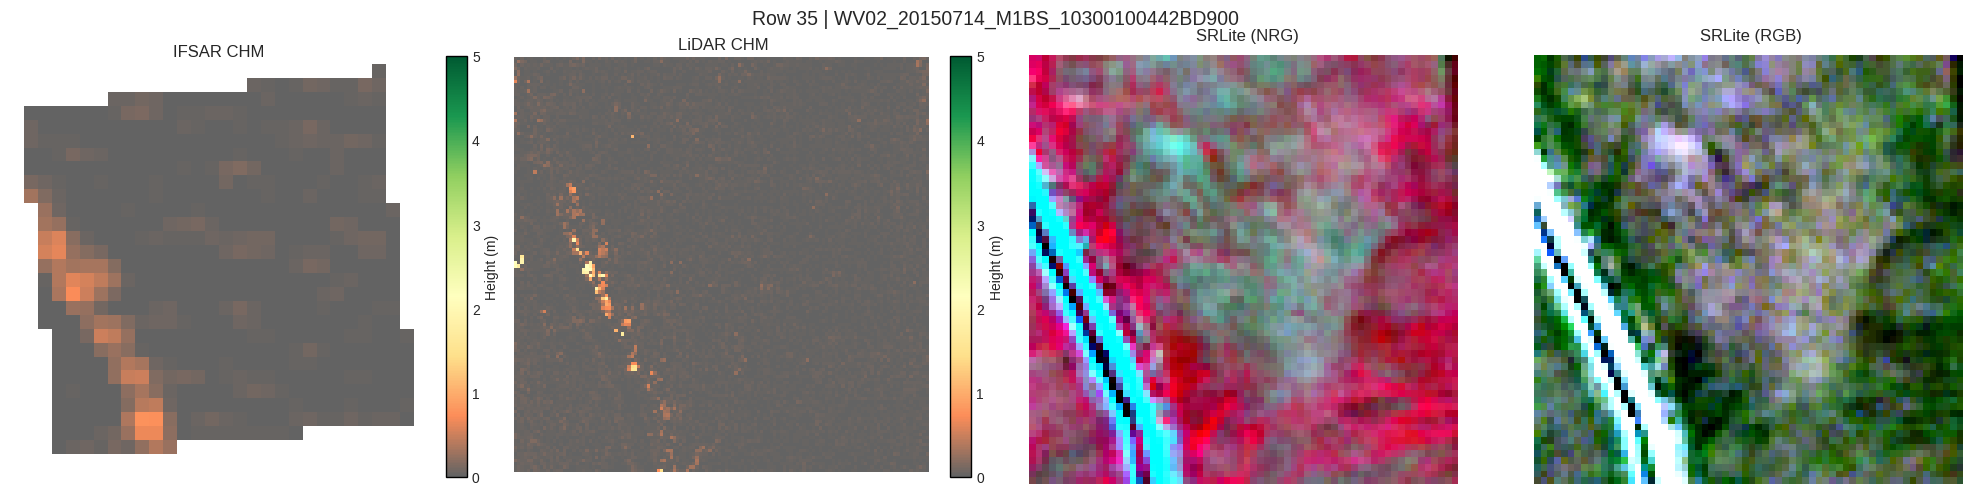


Row 36 | WV02_20150714_M1BS_10300100442BD900


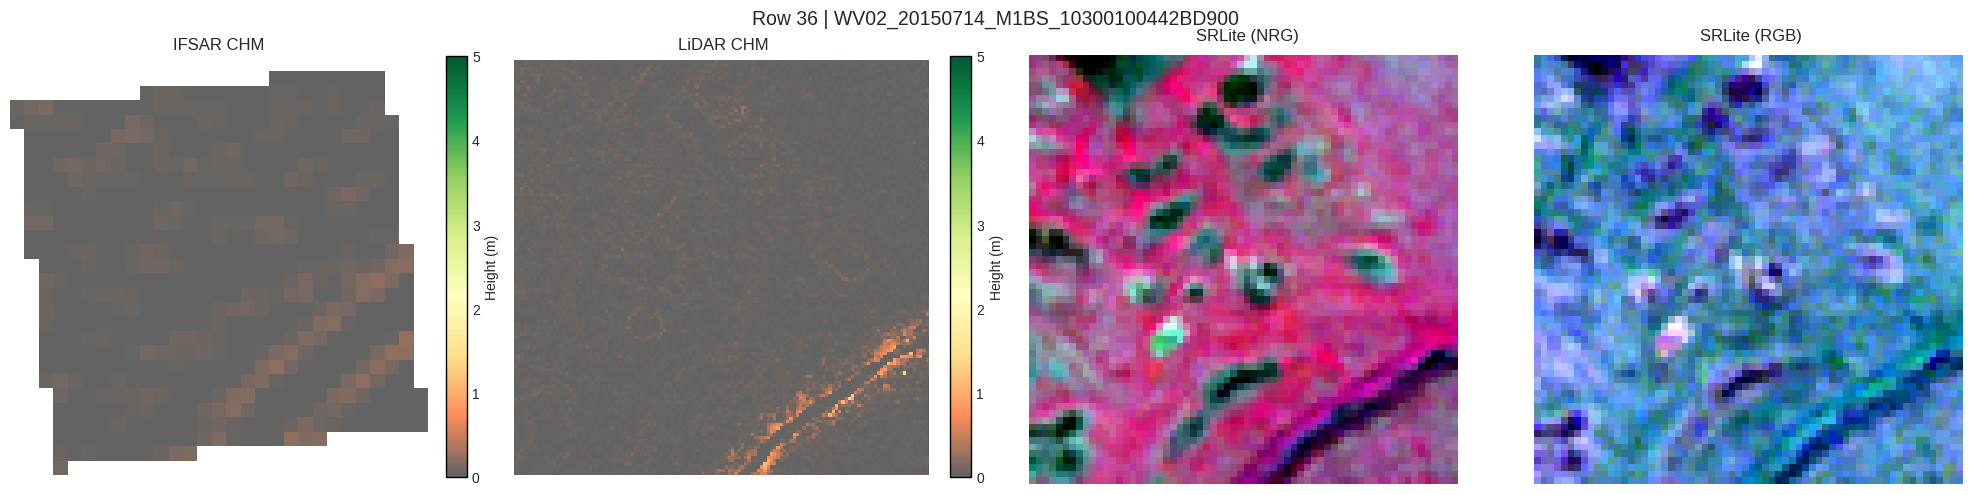


Row 37 | WV02_20150714_M1BS_10300100442BD900


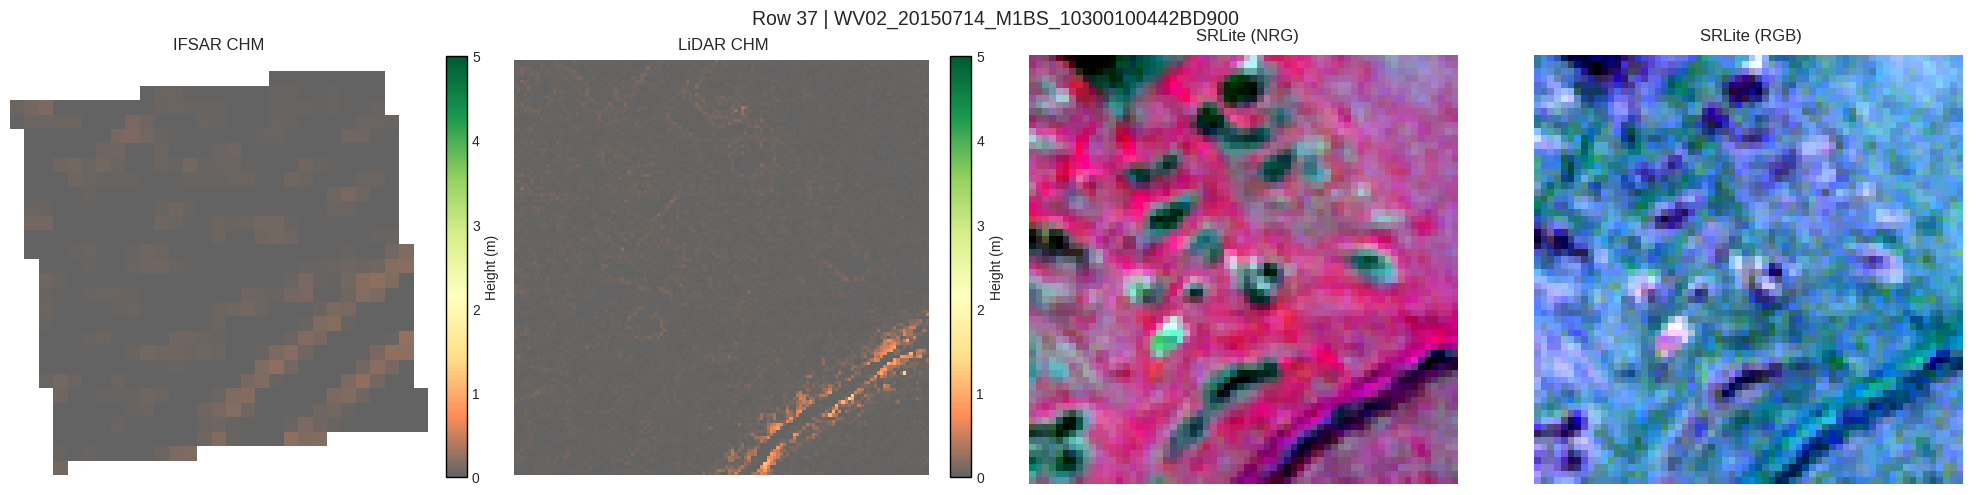


Row 38 | WV02_20150714_M1BS_10300100442BD900


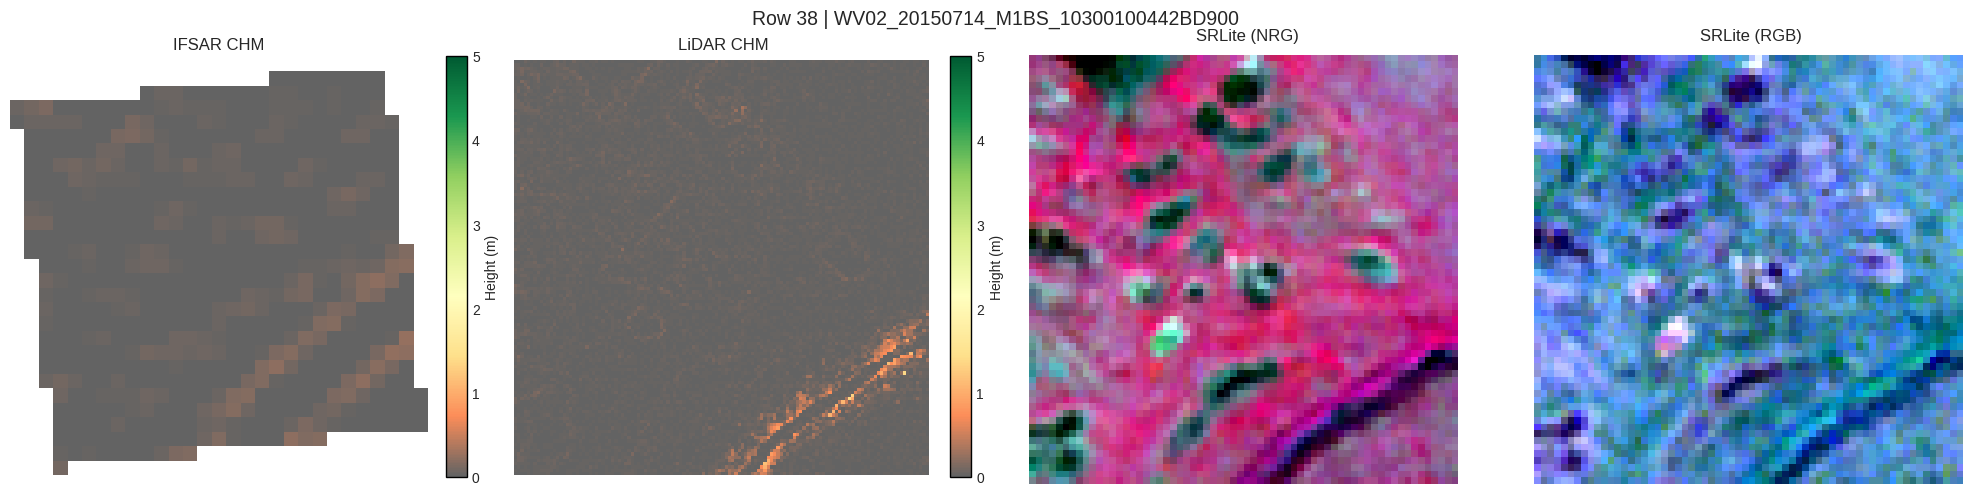


Row 39 | WV02_20150714_M1BS_10300100442BD900


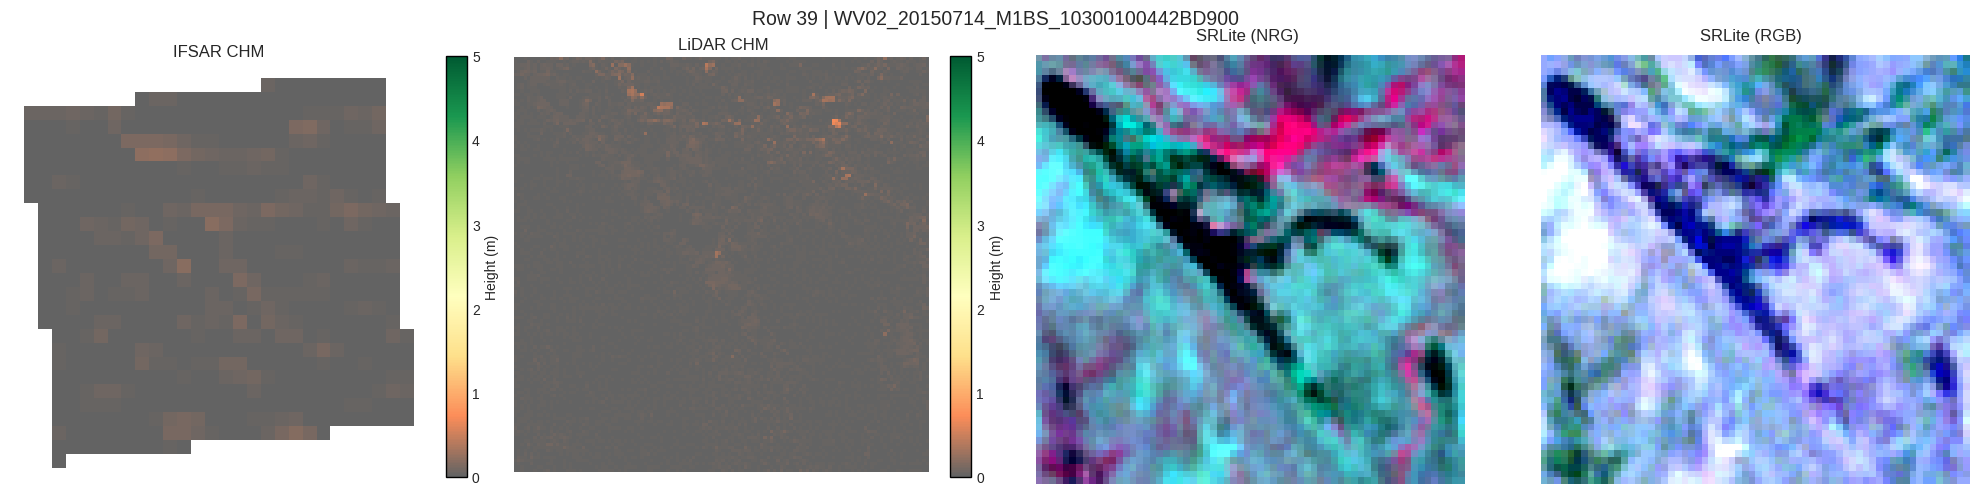


Row 40 | WV02_20150714_M1BS_10300100442BD900


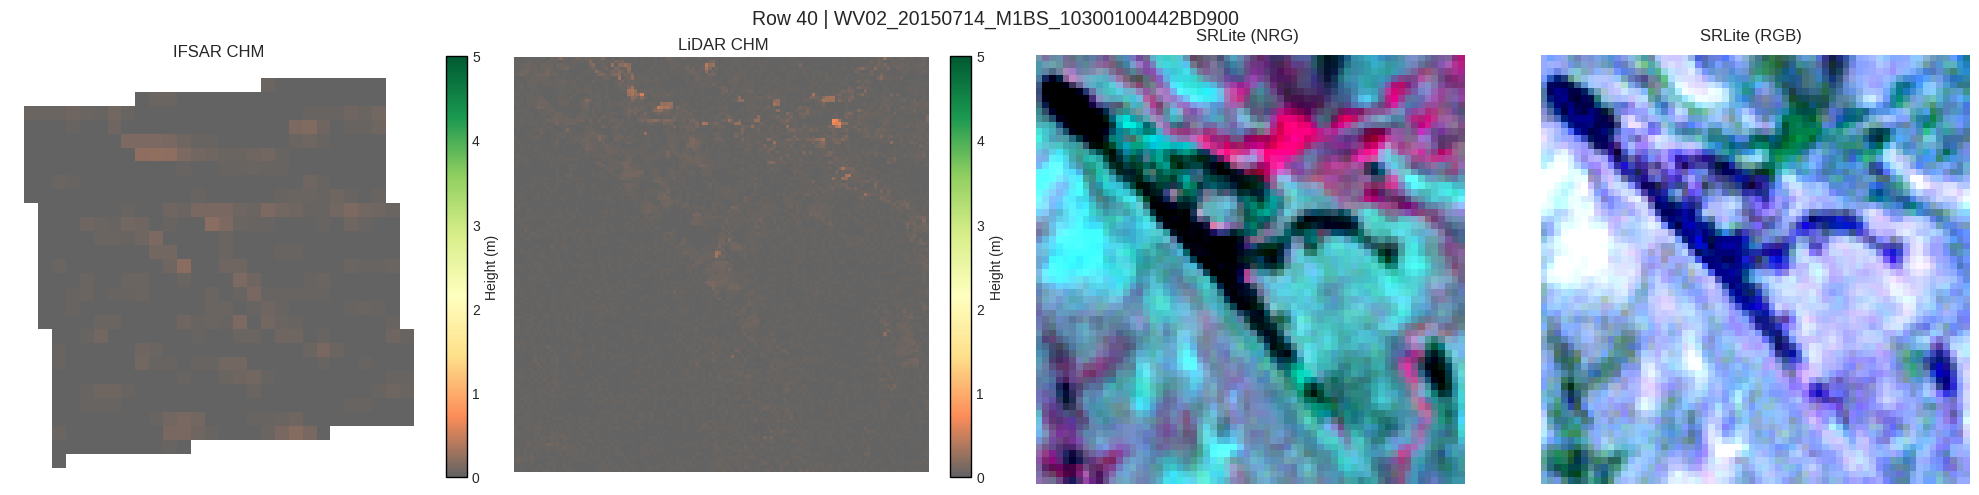


Row 41 | WV02_20150714_M1BS_10300100442BD900


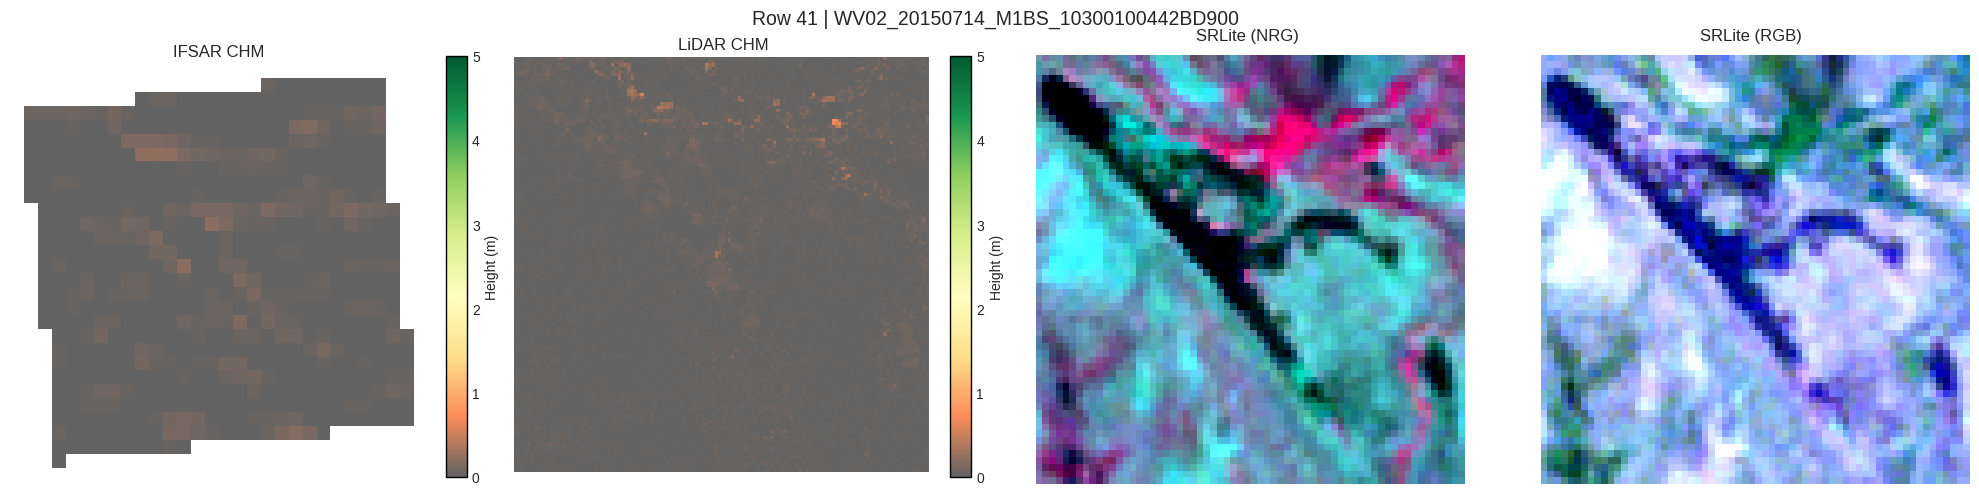


Row 42 | WV02_20150714_M1BS_10300100442BD900


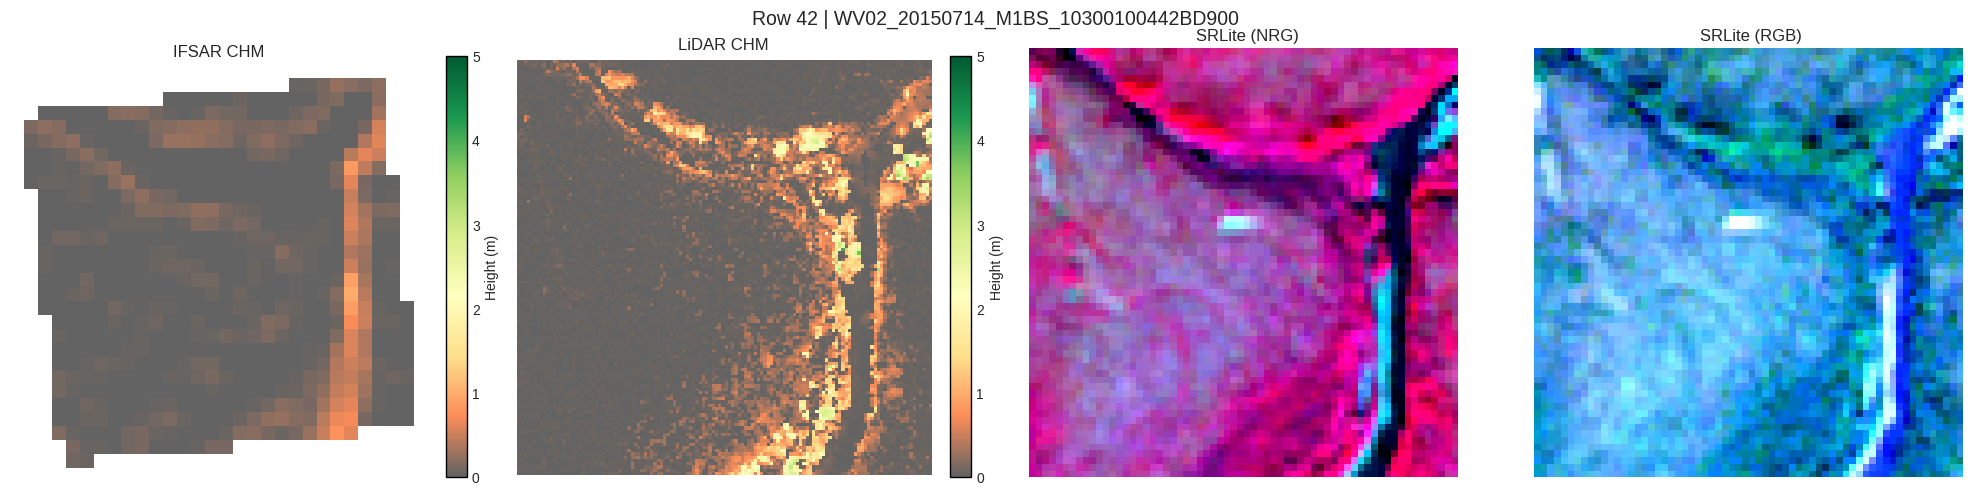


Row 43 | WV02_20150714_M1BS_10300100442BD900


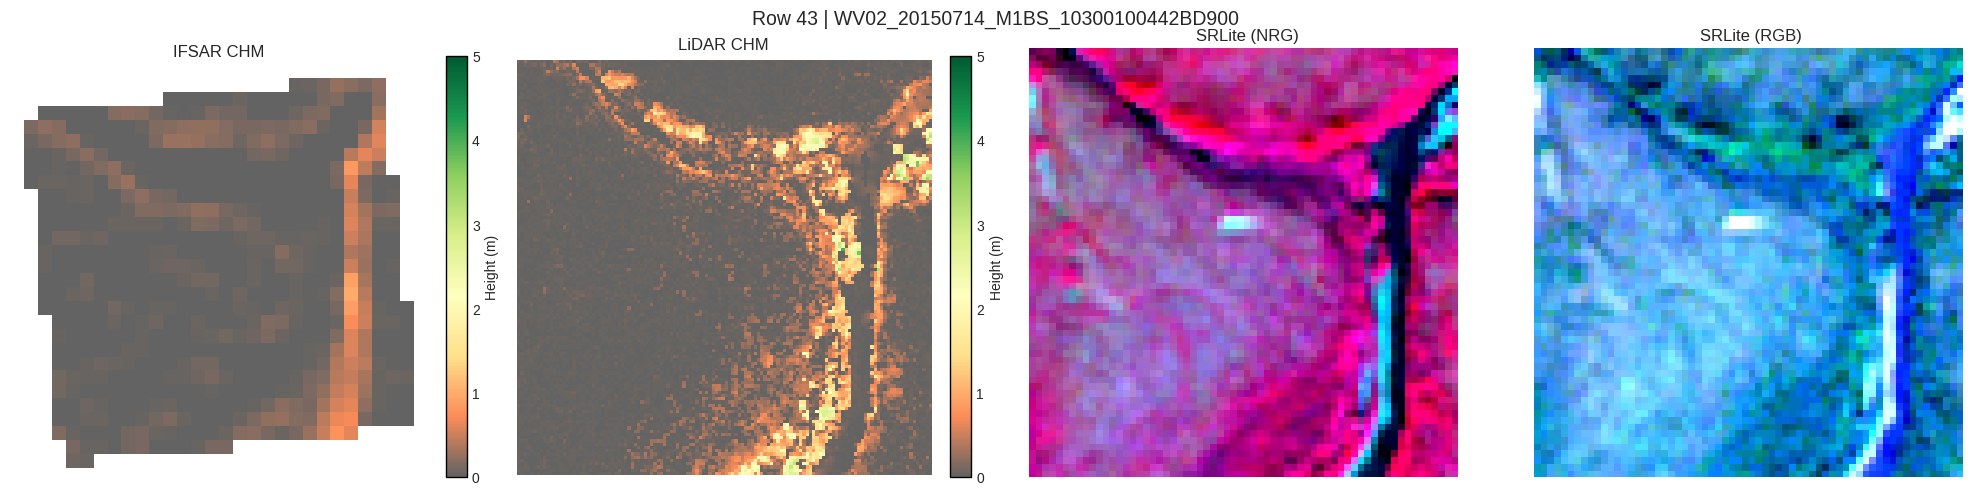


Row 44 | WV02_20150714_M1BS_10300100442BD900


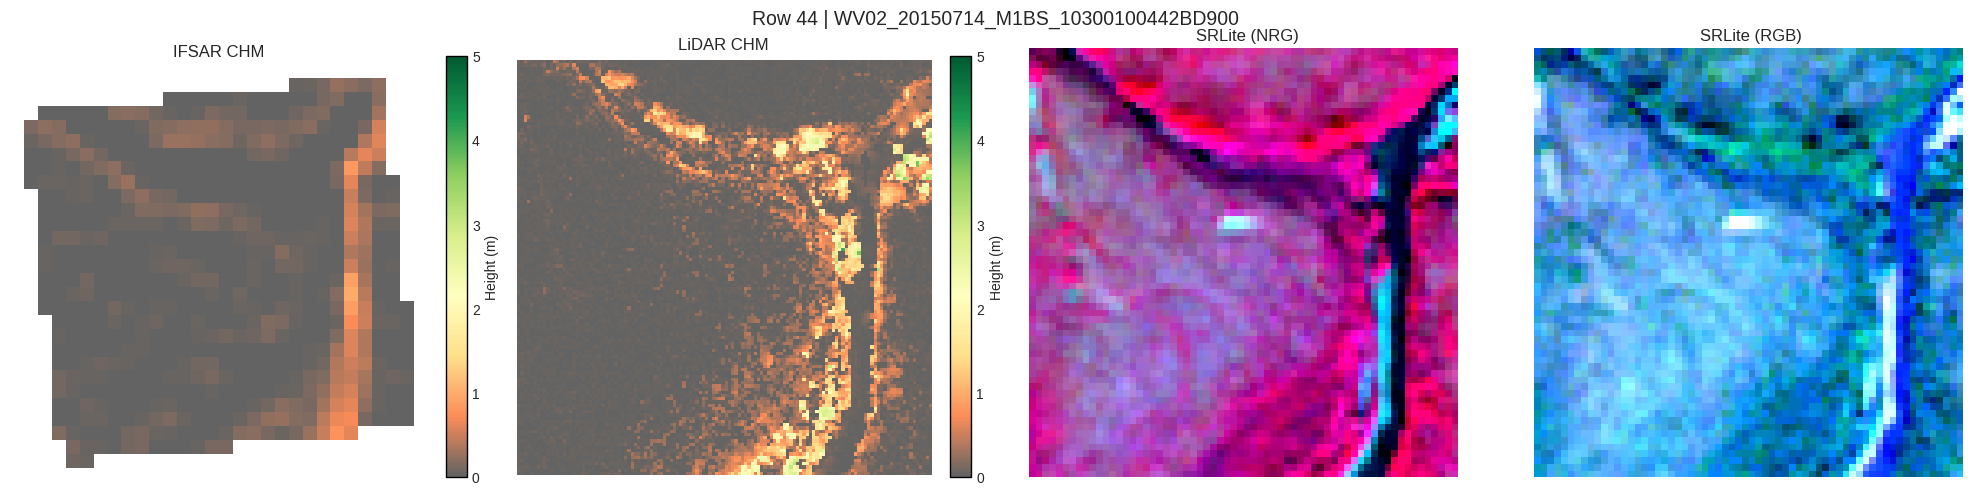


Row 45 | WV02_20150714_M1BS_10300100442BD900


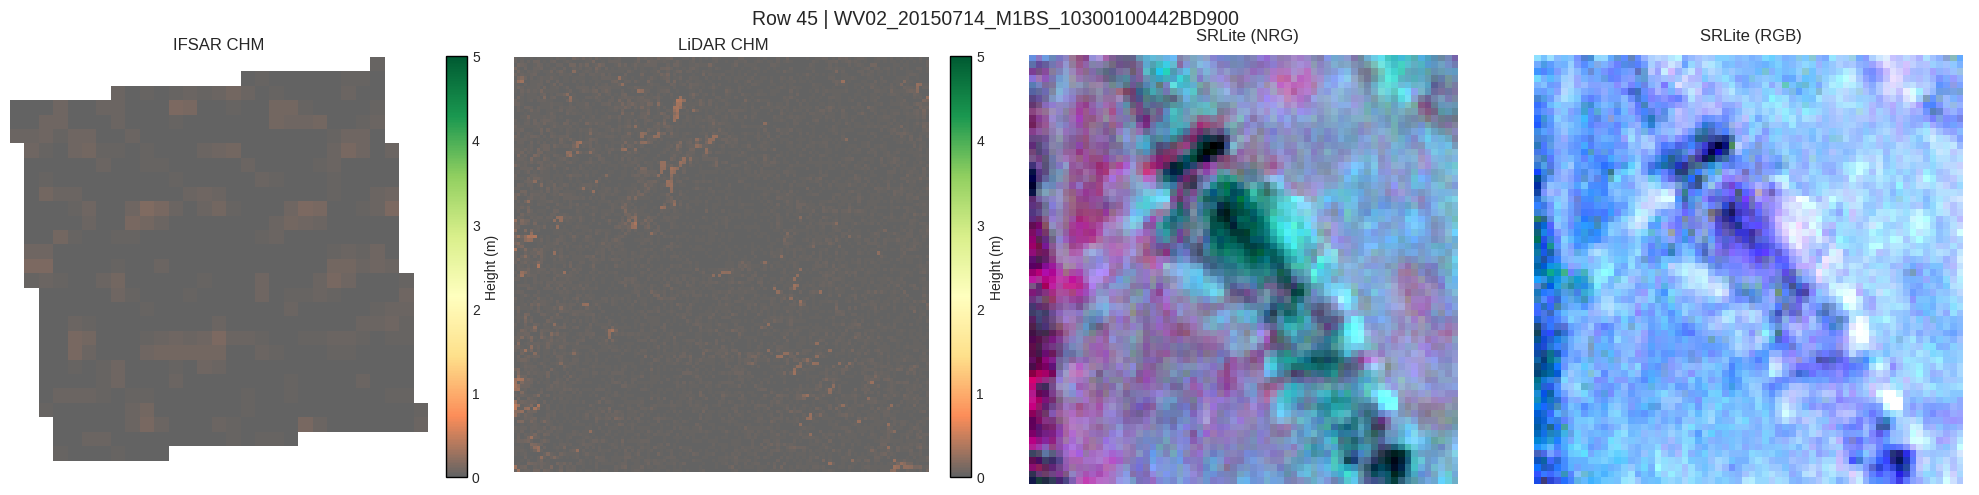


Row 46 | WV02_20150714_M1BS_10300100442BD900


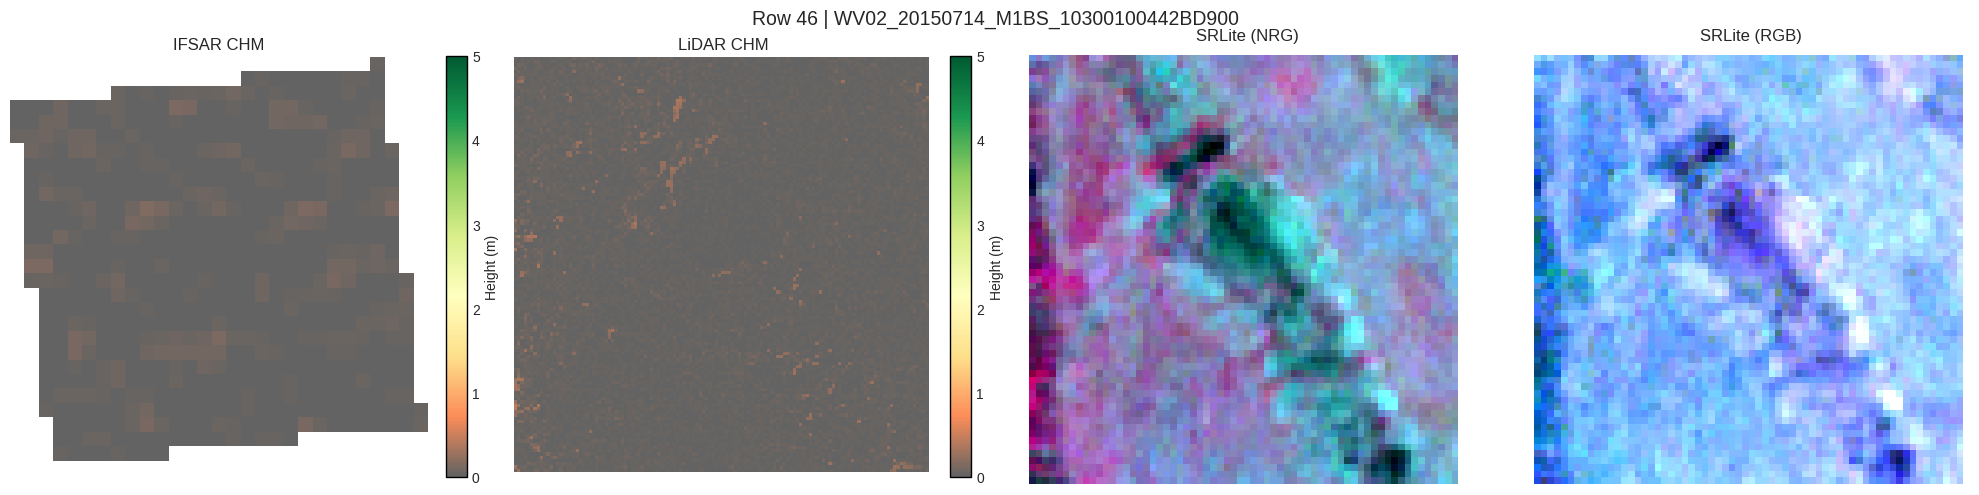


Row 47 | WV02_20150714_M1BS_10300100442BD900


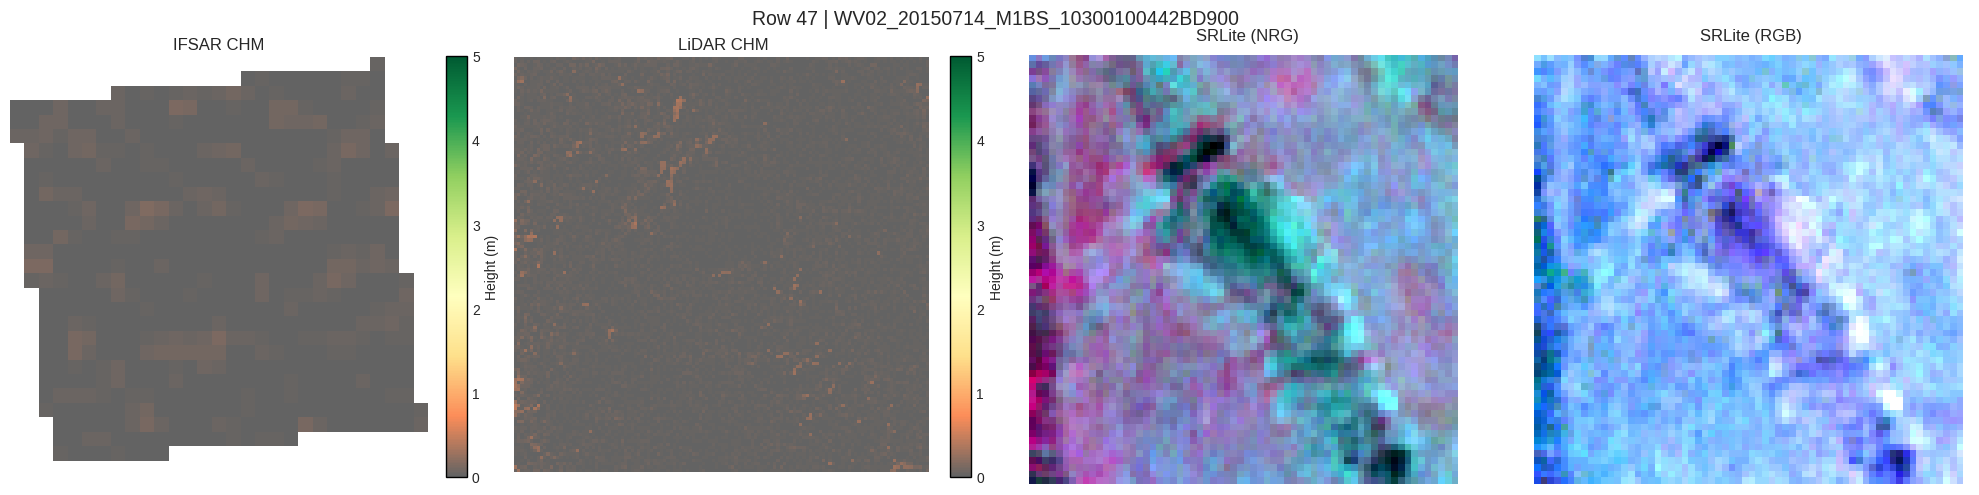


Row 48 | WV02_20150714_M1BS_10300100442BD900


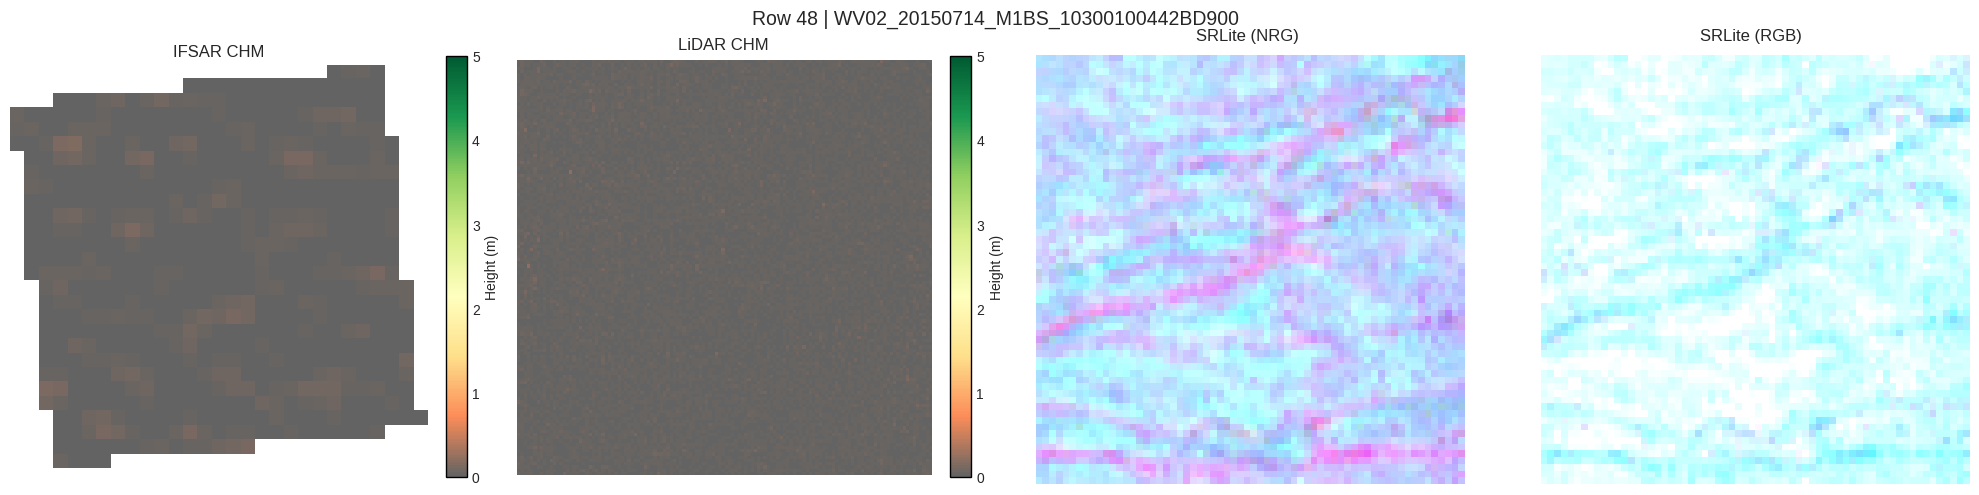


Row 49 | WV02_20150714_M1BS_10300100442BD900


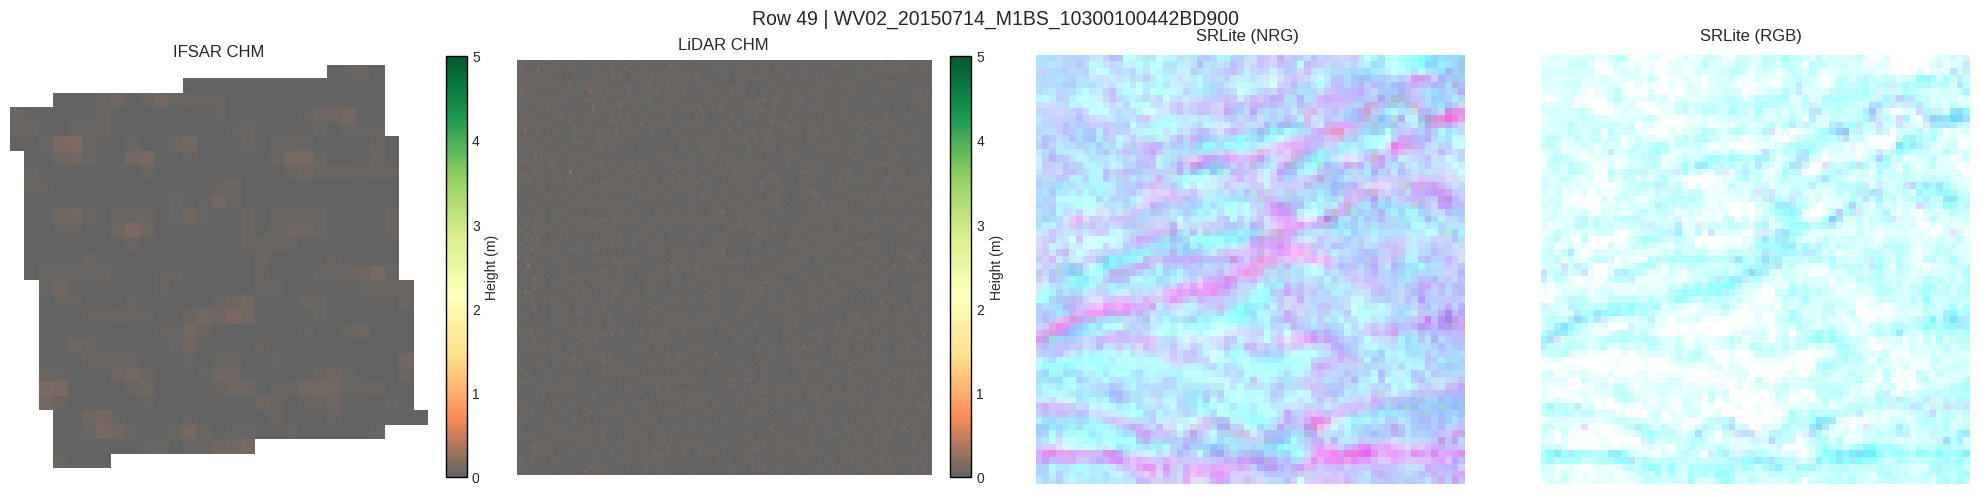


Row 50 | WV02_20150714_M1BS_10300100442BD900


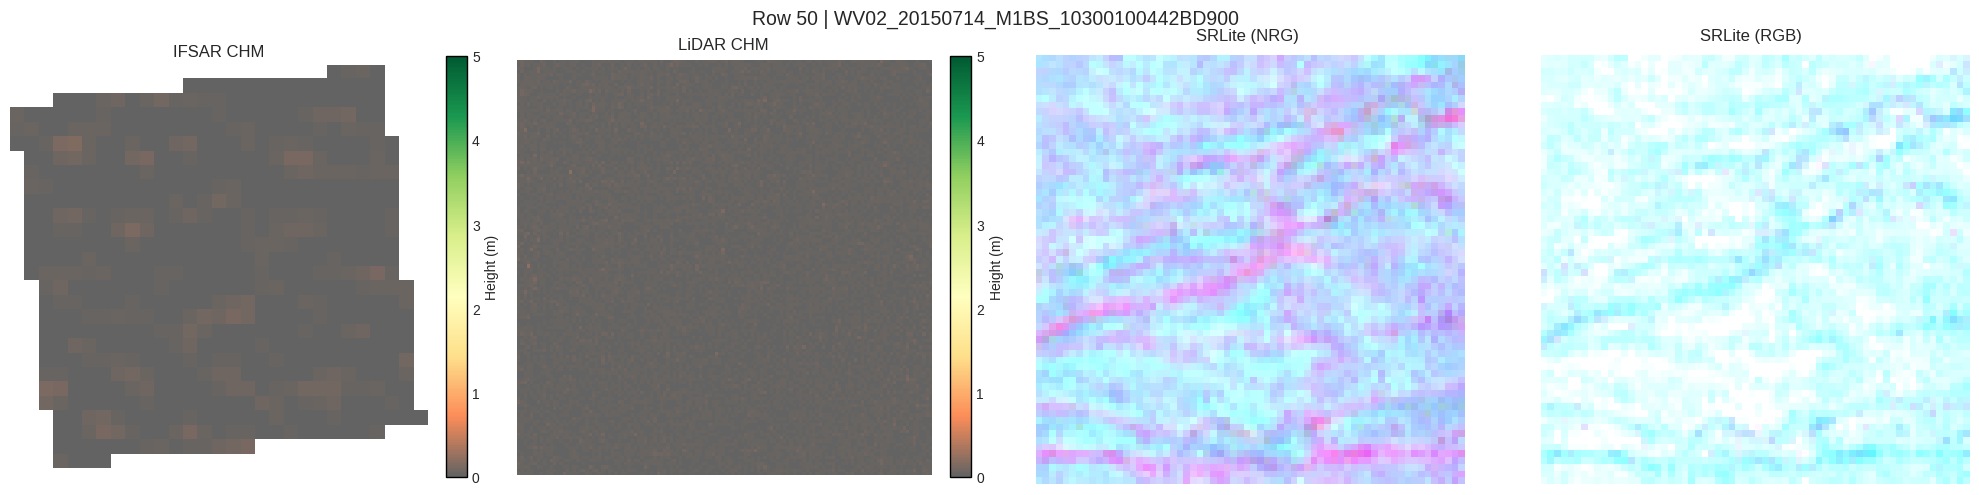


Row 51 | WV02_20150714_M1BS_10300100442BD900


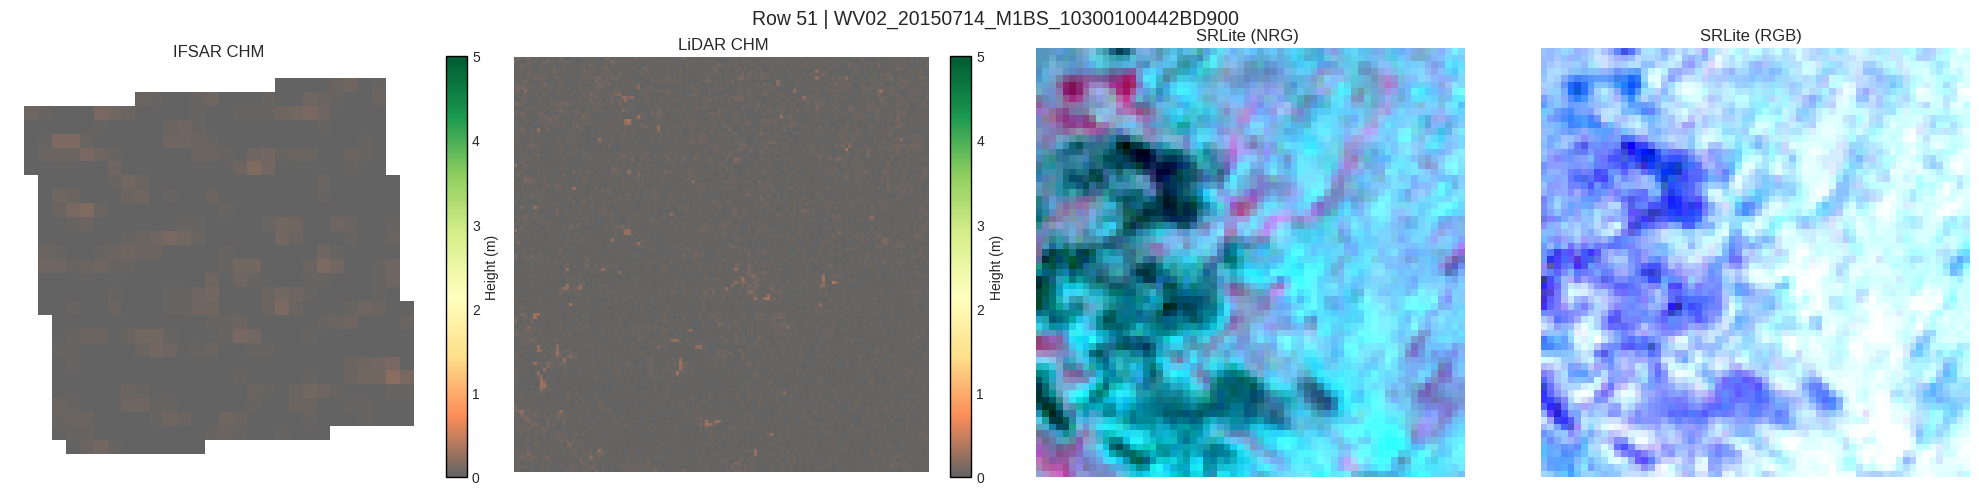


Row 52 | WV02_20150714_M1BS_10300100442BD900


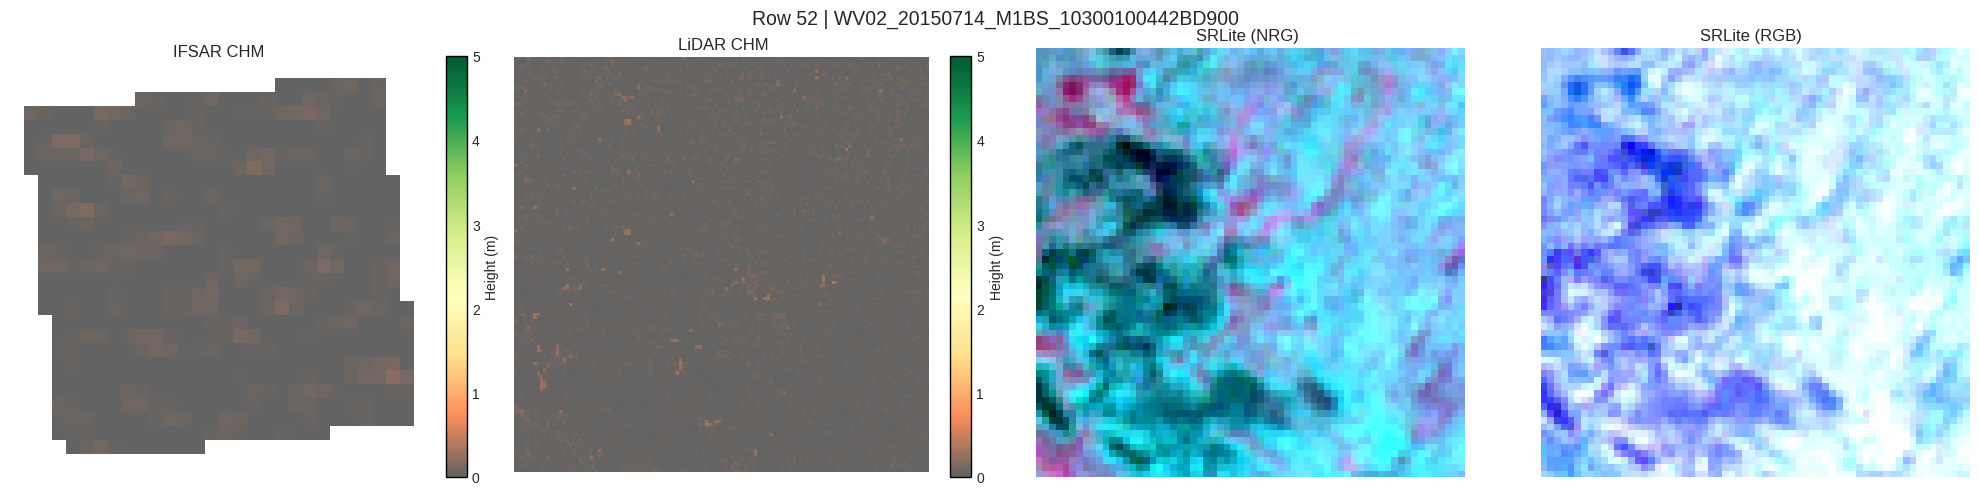


Row 53 | WV02_20150714_M1BS_10300100442BD900


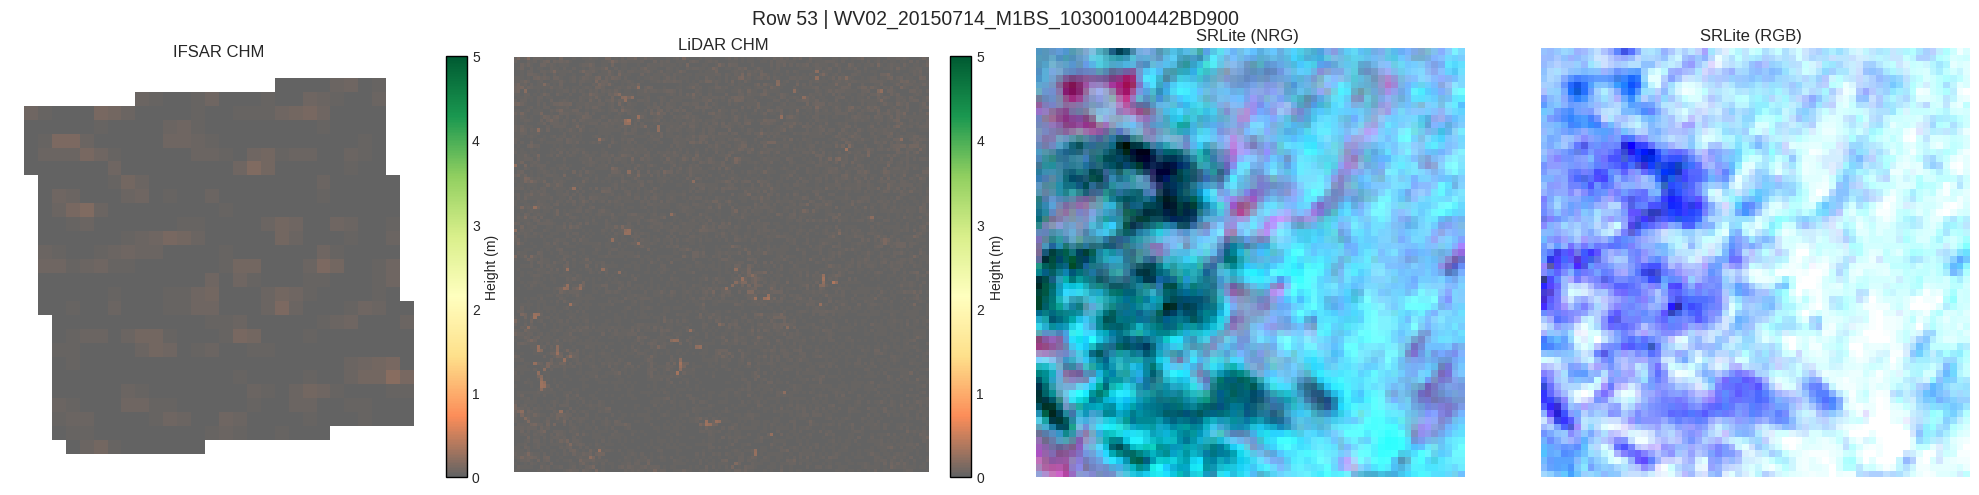


Row 54 | WV02_20150714_M1BS_10300100442BD900


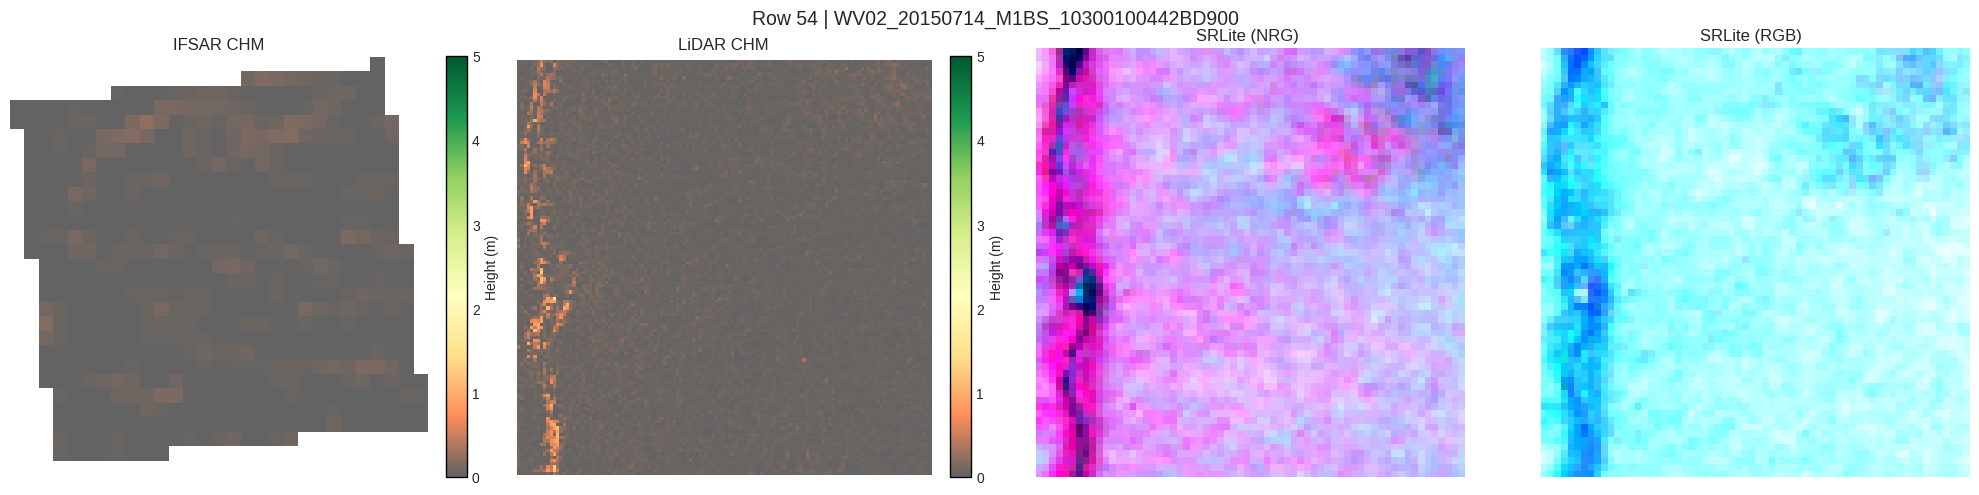


Row 55 | WV02_20150714_M1BS_10300100442BD900


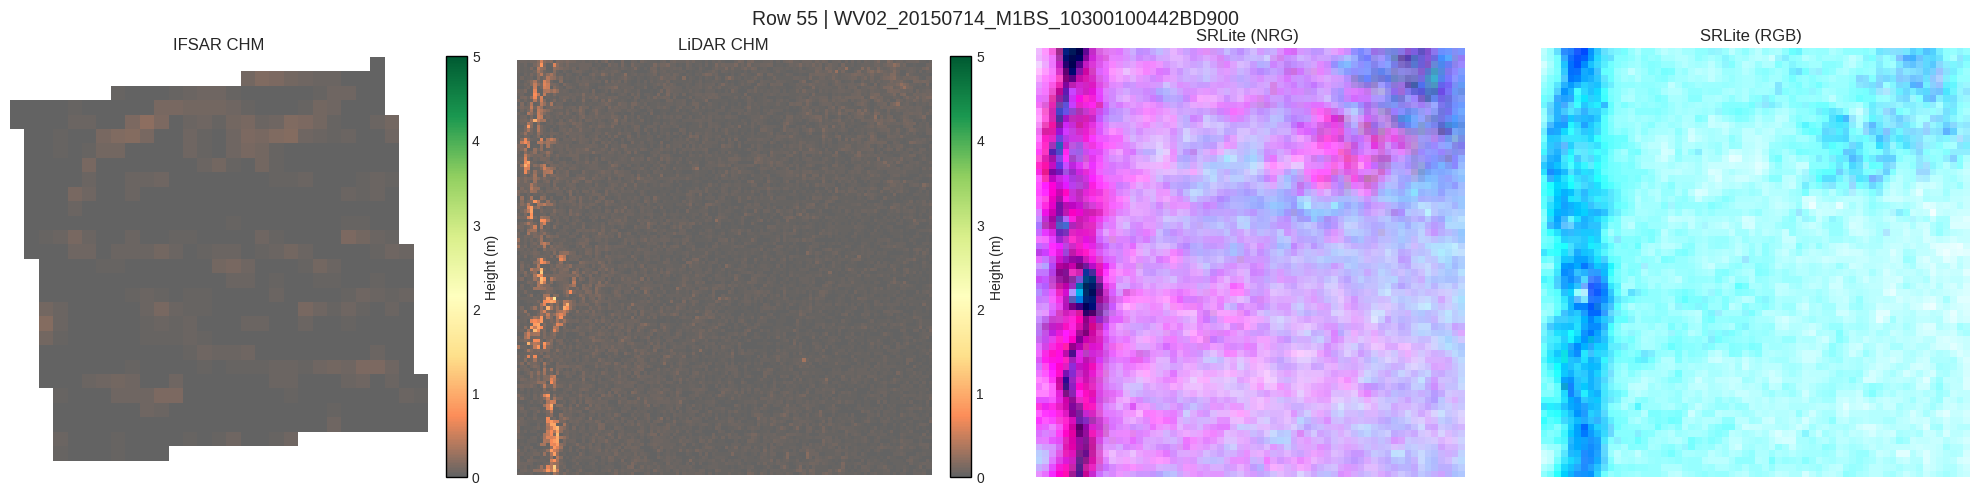


Row 56 | WV02_20150714_M1BS_10300100442BD900


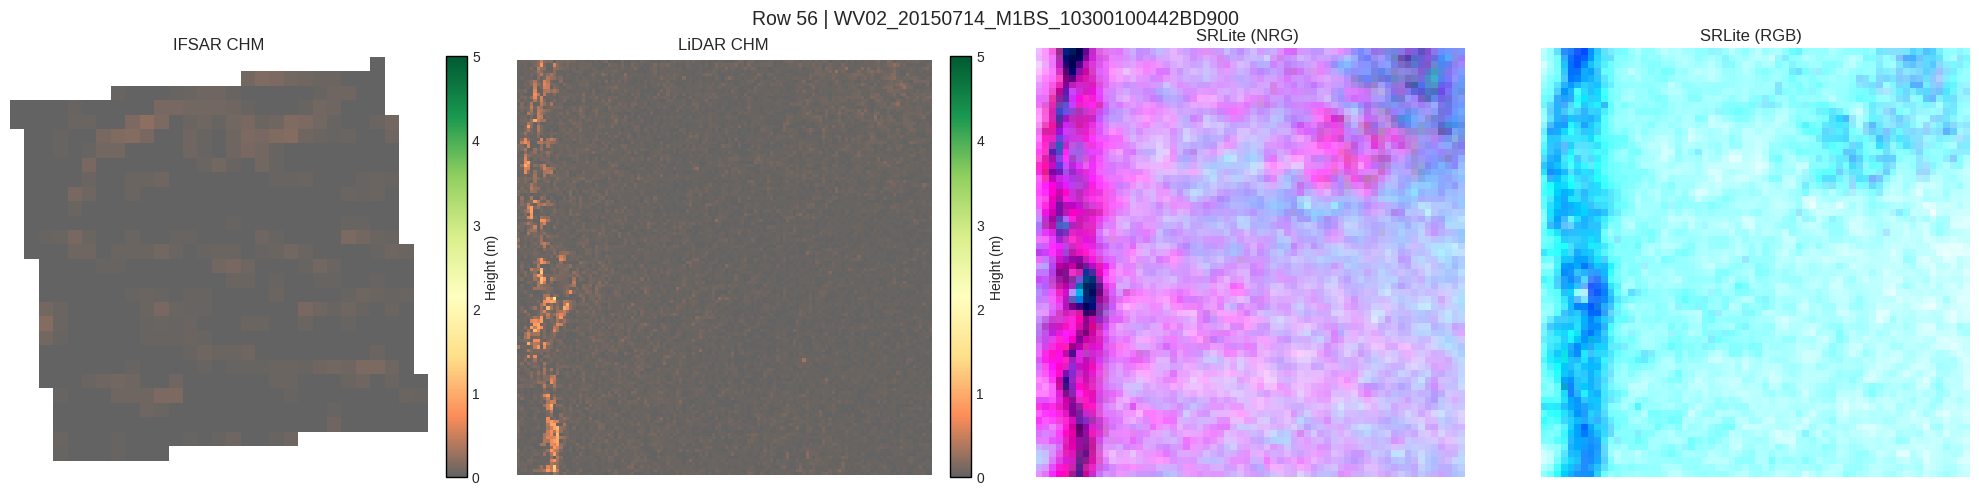


Row 57 | WV02_20150714_M1BS_10300100442BD900


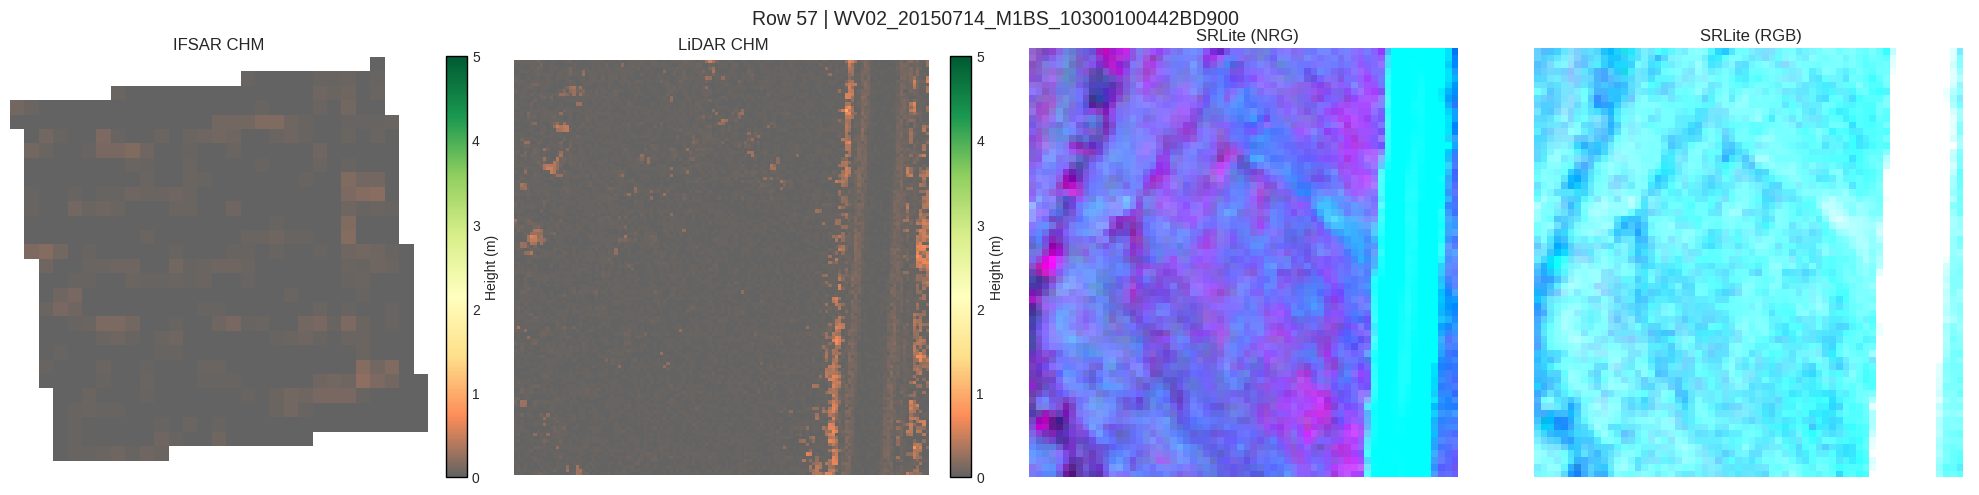


Row 58 | WV02_20150714_M1BS_10300100442BD900


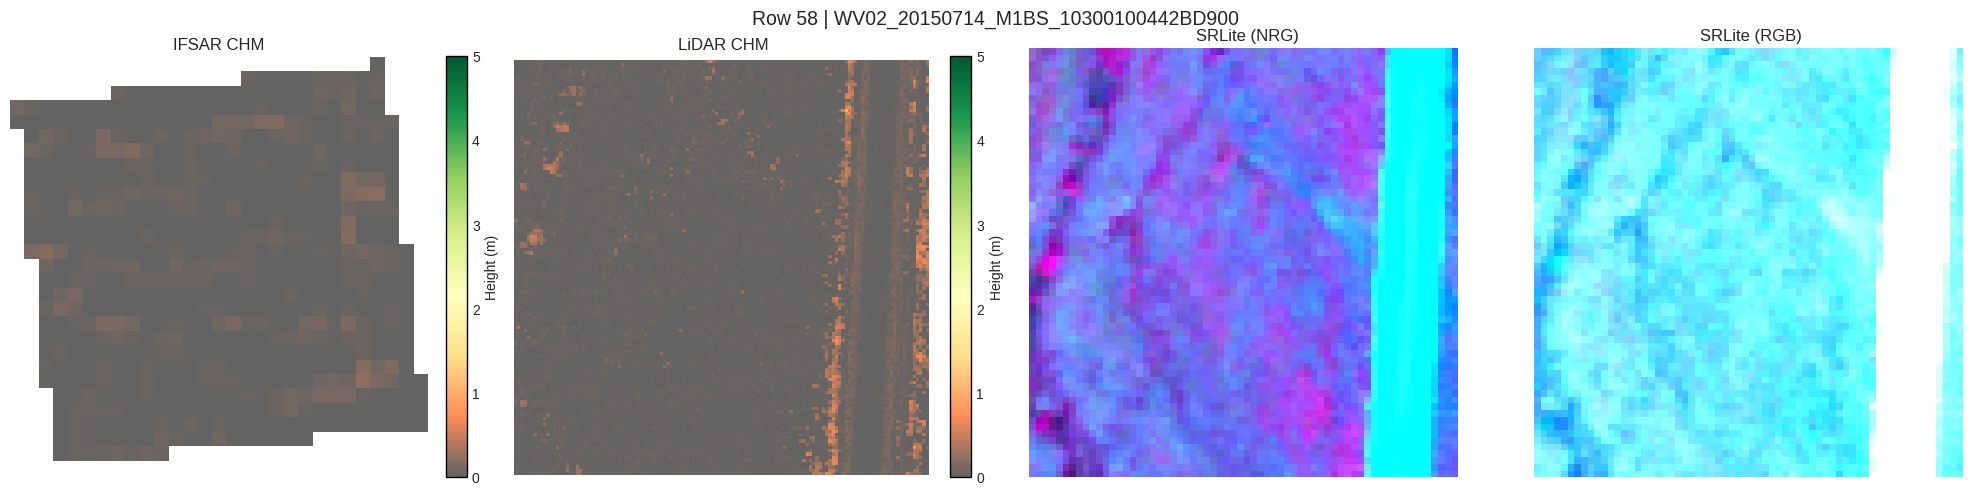


Row 59 | WV02_20150714_M1BS_10300100442BD900


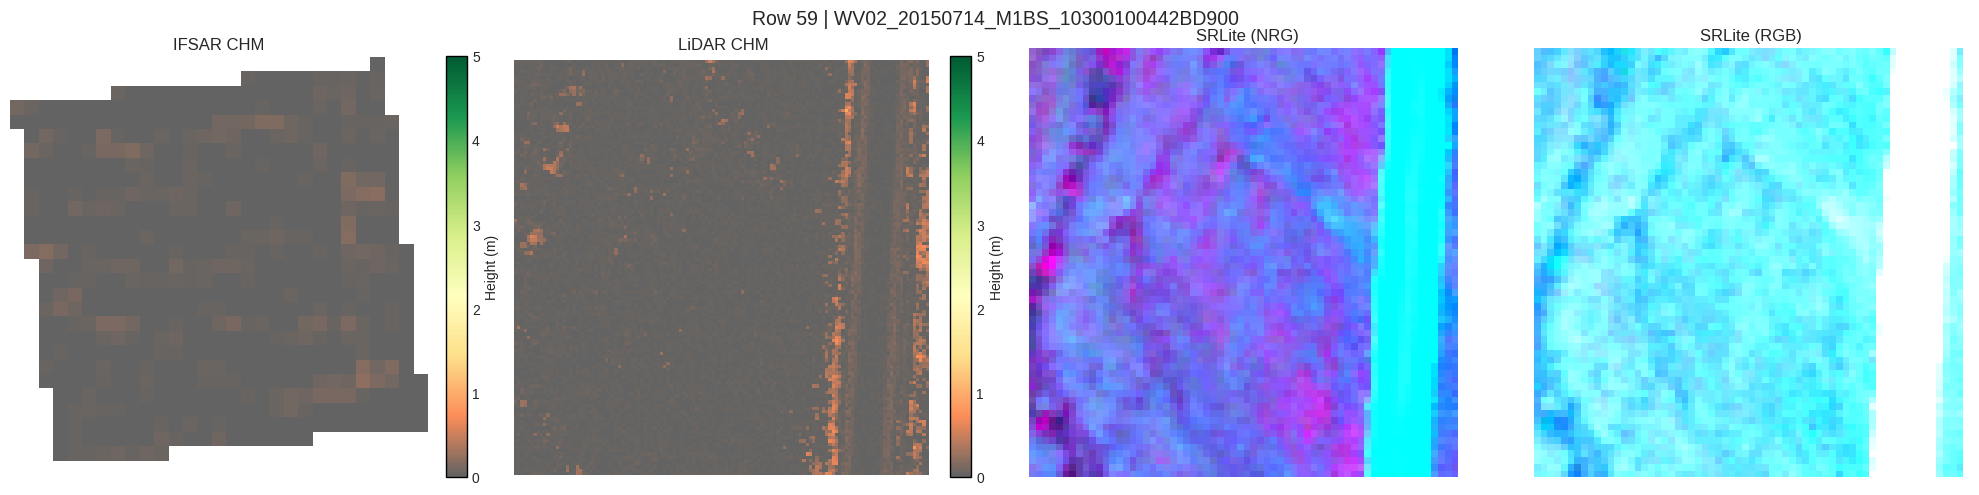


Row 60 | WV02_20150714_M1BS_10300100442BD900


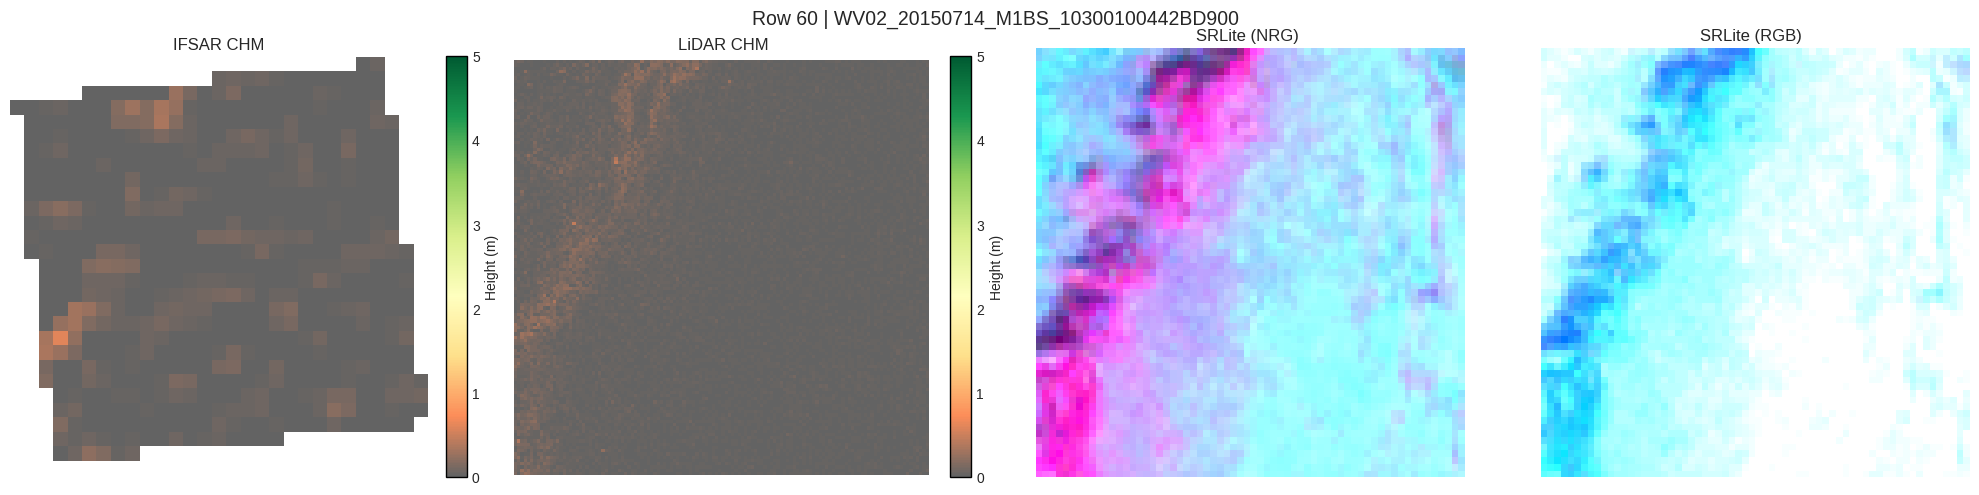


Row 61 | WV02_20150714_M1BS_10300100442BD900


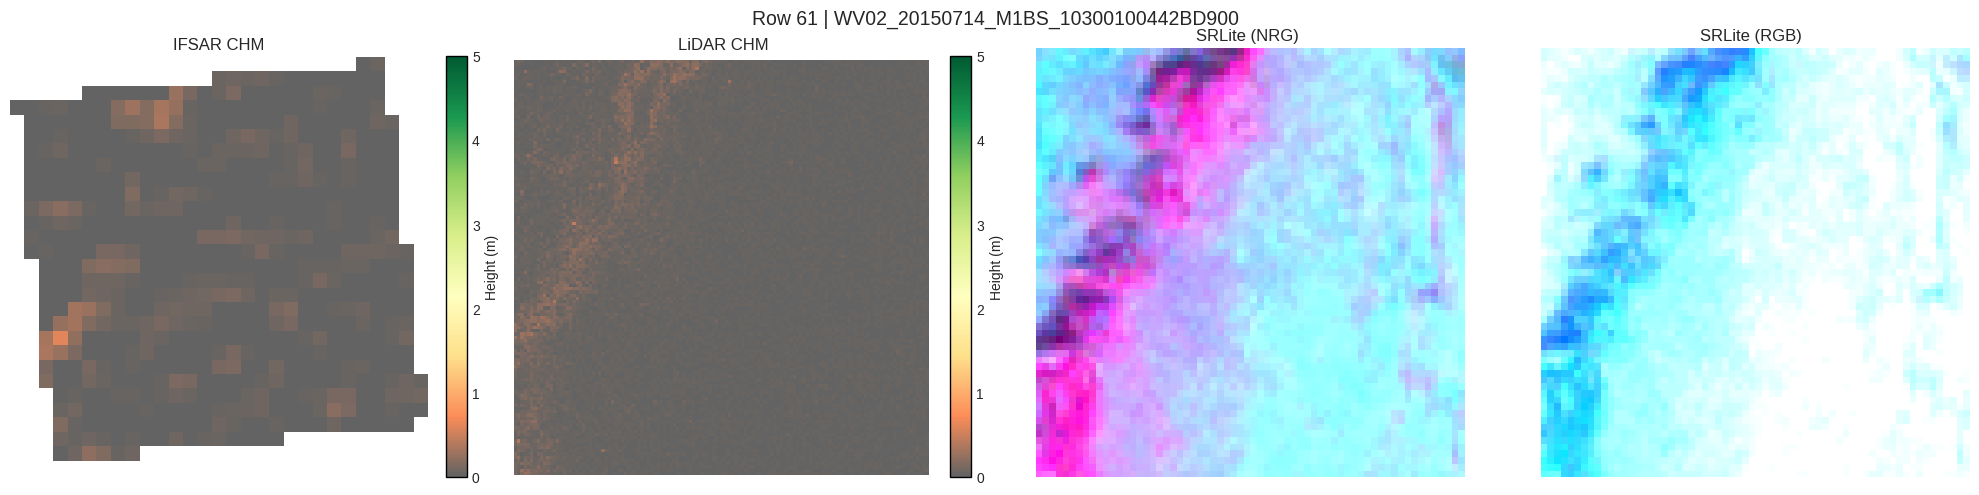


Row 62 | WV02_20150714_M1BS_10300100442BD900


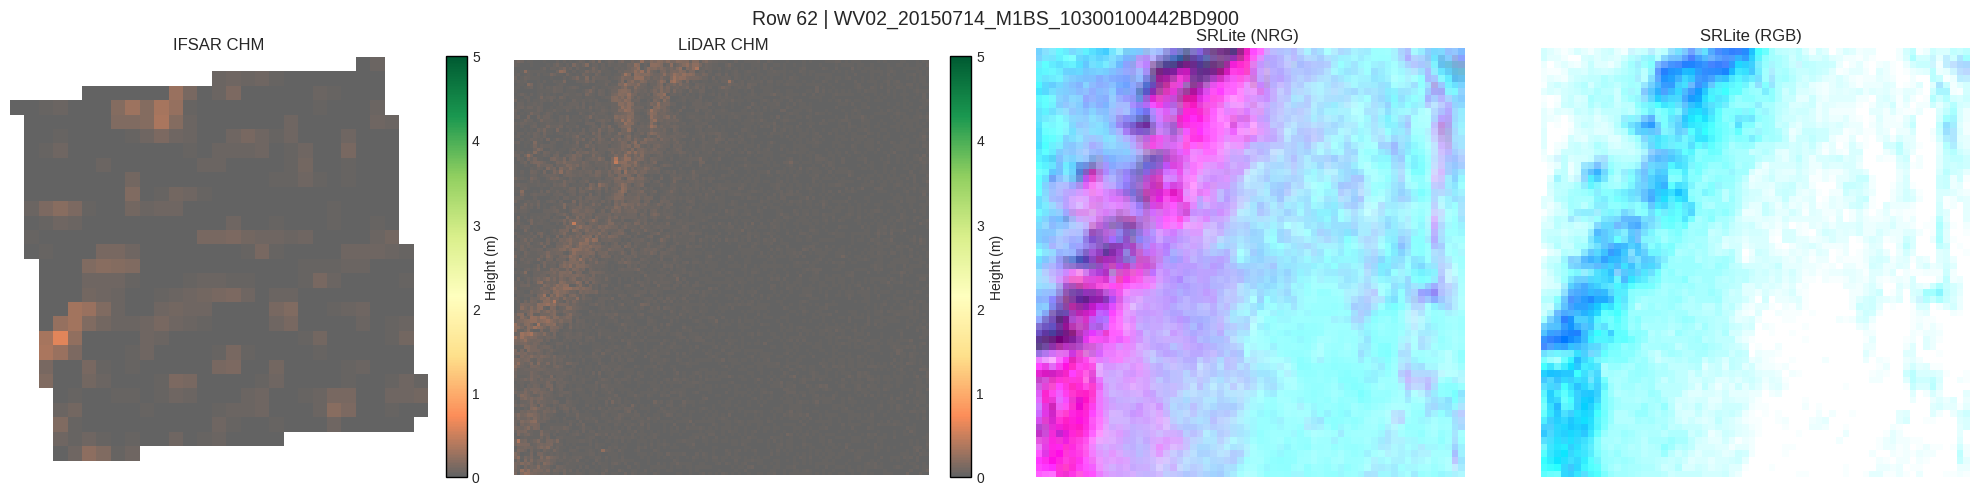

In [ ]:
# =============================================================================
# OPTIONAL: Explore rows to select your own vegetation type examples
# Change the row range or specific indices to explore different areas
#
# HOW TO USE:
# 1. Run this block to explore rows and identify good examples
# 2. Note the row numbers for each vegetation type you want
# 3. Update the vegetation_types dictionary in the next block:
#
#    vegetation_types = {
#        'Tundra': [YOUR_ROW_NUMBER],
#        'Woody (sparse)': [YOUR_ROW_NUMBER],
#        'Woody (dense)': [YOUR_ROW_NUMBER],
#        'Mixed': [YOUR_ROW_NUMBER]  
#    }
# =============================================================================

# Option 1: Loop through a range of rows
start_row = 0
end_row = 100

for idx in range(start_row, min(end_row, len(gdf_overlap))):
    row = gdf_overlap.iloc[idx]
    
    files = {
        'IFSAR CHM': row['chmPath_left'],
        'LiDAR CHM': row['chmPath_right'],
        'SRLite': row['srlite_real_path']
    }
    
    print(f"\n{'='*60}")
    print(f"Row {idx} | {row['baseName_left']}")
    print(f"{'='*60}")
    
    clipped_arrays = {}
    skip_row = False
    
    for name, filepath in files.items():
        try:
            arr = clip_raster_with_geom(filepath, row.geometry, gdf_crs)
            if 'CHM' in name:
                arr = arr.astype(float)
                arr[(arr > 40) | (arr < -5)] = np.nan
            clipped_arrays[name] = arr
        except Exception as e:
            print(f"  Error loading {name}: {e}")
            skip_row = True
            break
    
    if skip_row:
        continue
    
    # Plot 4 panels: IFSAR CHM, LiDAR CHM, SRLite NRG, SRLite RGB
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    fig.suptitle(f"Row {idx} | {row['baseName_left']}", fontsize=14)
    
    srlite_arr = clipped_arrays['SRLite']
    
    # Panel 1: IFSAR CHM
    ax = axes[0]
    im = ax.imshow(clipped_arrays['IFSAR CHM'][0], cmap=forest_ht_cmap, norm=norm)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label='Height (m)')
    ax.set_title('IFSAR CHM')
    ax.axis('off')
    
    # Panel 2: LiDAR CHM
    ax = axes[1]
    im = ax.imshow(clipped_arrays['LiDAR CHM'][0], cmap=forest_ht_cmap, norm=norm)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label='Height (m)')
    ax.set_title('LiDAR CHM')
    ax.axis('off')
    
    # Panel 3: SRLite NRG (False color)
    ax = axes[2]
    nir = srlite_arr[3]
    red = srlite_arr[2]
    green = srlite_arr[1]
    
    nir_stretched = stretch_band_fixed(nir, stretch_params['nir_min'], stretch_params['nir_max'])
    red_stretched = stretch_band_fixed(red, stretch_params['red_min'], stretch_params['red_max'])
    green_stretched = stretch_band_fixed(green, stretch_params['green_min'], stretch_params['green_max'])
    
    nrg = np.dstack([nir_stretched, red_stretched, green_stretched])
    ax.imshow(nrg)
    ax.set_title('SRLite (NRG)')
    ax.axis('off')
    
    # Panel 4: SRLite RGB (True color)
    ax = axes[3]
    red = srlite_arr[2]
    green = srlite_arr[1]
    blue = srlite_arr[0]
    
    red_stretched = stretch_band_fixed(red, stretch_params['red_min'], stretch_params['red_max'])
    green_stretched = stretch_band_fixed(green, stretch_params['green_min'], stretch_params['green_max'])
    blue_stretched = stretch_band_fixed(blue, stretch_params['blue_min'], stretch_params['blue_max'])
    
    rgb = np.dstack([red_stretched, green_stretched, blue_stretched])
    ax.imshow(rgb)
    ax.set_title('SRLite (RGB)')
    ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# =============================================================================
# Option 2: View specific rows only
# Uncomment and modify the list below to view specific row indices
# =============================================================================
# specific_rows = [66, 97, 122, 183, 204, 319, 458]
# 
# for idx in specific_rows:
#     row = gdf_overlap.iloc[idx]
#     ... same code as above ...